In [1]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import torch
import pickle 
import pandas as pd
import math
#from sklearnex import patch_sklearn
#patch_sklearn()

from scipy import special
import os
import multiprocessing as mp


import numba as nb
import time 
from scipy import interpolate

import corner

from pymultinest.solve import solve, run

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
plt.rcParams['figure.figsize'] = (9, 6)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
colormap={0:'red',1:'green'}
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True 
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['font.size'] = 12

import json
from tensorflow_probability.python.mcmc import hmc
#loading observations
from PyAstronomy import pyasl
from observation import load_observations
from chi_computations import chi_window,chi_squared,chi_squared_reduced
from para_transform import para_to_parameterin
from rout import adjust_rout
from data_prep import load_para_input
from dict_f import log_dict
from star_hrd import *



import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp


import tensorflow_addons as tfa

2023-09-06 12:08:06.174935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's rea

In [2]:

name='single_46_opti'


name_incl='shielded_single_04'
#name='single_23_wo_wrongall3'
#name='single_42_onlyshortmodels_200' # what network to use
star_name='star_m-only_3' #what network for mass prediction of star
path_data='./data/' #where is the downloaded data
bayesian_folder='./Output/'


# functions needed to calculate the likelihood

### idea of calculating a fine in/out array and just calculating the closest entry to make it less computationally expensive 

In [4]:
#creating array that is larger than the prior
num_p=10**3

#num_p=10**2 #for testing only

lstar_range=np.linspace(-1.6,1.8,num_p)
teff_range=np.linspace(3.45, 4.03,num_p)

lstar_range_tf=tf.constant(lstar_range,'float32')
teff_range_tf=tf.constant(teff_range,'float32')

star_in_hrd=np.load('./data/HRD_mask.npy')

running the same code again, but selecting only a smaller area in which we want the walkers to start

to create the area we demand that the point but also teff and lstar seperately increased or decreased by 5% are within the allowed area. In this way points that have a value of teff or lstar within 5% of the boundry are excluded

In [5]:

star_in_hrd_strict=np.load('./data/HRD_mask_strict.npy')

In [6]:
star_in_hrd_tf=tf.constant(star_in_hrd)
star_in_hrd_strict_tf=tf.constant(star_in_hrd_strict)

In [7]:
def check_if_in_mask(temp,lum,debug=False):
    idx_temp_hrd=tf.math.argmin(abs(tf.subtract(teff_range_tf,temp)))
    idx_lstar_hrd=tf.math.argmin(abs(tf.subtract(lstar_range_tf,lum)))
    if debug:
        print('idx temp',idx_temp_hrd)
        print('idx ltar',idx_lstar_hrd)
        print(teff_range_tf[idx_temp_hrd])
        print(lstar_range_tf[idx_lstar_hrd])
    return star_in_hrd_tf[idx_temp_hrd,idx_lstar_hrd]

In [8]:
def check_if_in_strict_mask(temp,lum,debug=False):
    idx_temp_hrd=tf.math.argmin(abs(tf.subtract(teff_range_tf,temp)))
    idx_lstar_hrd=tf.math.argmin(abs(tf.subtract(lstar_range_tf,lum)))
    if debug:
        print('idx temp',idx_temp_hrd)
        print('idx ltar',idx_lstar_hrd)
        print(teff_range_tf[idx_temp_hrd])
        print(lstar_range_tf[idx_lstar_hrd])
    return star_in_hrd_strict_tf[idx_temp_hrd,idx_lstar_hrd]

In [9]:
scaler=joblib.load(f'{path_data}/scaler/{name}_para_scaler.save')
y_scaler=joblib.load(f'{path_data}/scaler/{name}_sed_scaler.save')

/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
try:
    model_saved=load_model(f'{path_data}/NeuralNets/{name}.h5',compile=False)
except:
    model_saved=load_model(f'{path_data}/{name}.h5',compile=False)


In [11]:
#inclination neural nets that tells if a star is shielded and therefore excluded from our analysis

lim_shielded=0.072104424

incl_scaler=joblib.load(f'{path_data}/scaler/{name_incl}_para_scaler.save')
incl_y_scaler=joblib.load(f'{path_data}/scaler/{name_incl}_sed_scaler.save')
try:
    incl_model_saved=load_model(f'{path_data}/NeuralNets/{name_incl}.h5',compile=False)
except:
    incl_model_saved=load_model(f'{path_data}/{name_incl}.h5',compile=False)


/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:

def NN_star_init(star_name=star_name,path_starNN_data=path_data+'/star_NN'):
    scaler=joblib.load(f'{path_starNN_data}/scaler/{star_name}_input_scaler.save')
    '''
    input scaler
    '''
    yscaler=joblib.load(f'{path_starNN_data}/scaler/{star_name}_output_scaler.save')
    '''
    output scaler
    '''
    NN=load_model(f'{path_starNN_data}/{star_name}.h5',compile=False)
    return scaler,yscaler,NN
star_mass_scaler,star_mass_yscaler,star_mass_NN=NN_star_init()

/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# tricking scaler 
Checking what the values of the scalers are, so that I can run them outside sklearn. This allows eveything to be tensors and also makes it faster

In [13]:
scaler_dict={}
#input scaler of NN
z1=scaler.transform(np.zeros((1,18)))
z2=scaler.transform(np.ones((1,18)))
s_input=1/(z2-z1) #important
u_input=-z1/(z2-z1) #important
scaler_dict['Input_NN']={}
scaler_dict['Input_NN']['s']=s_input
scaler_dict['Input_NN']['u']=u_input

#output scaler of NN
z1_out=y_scaler.transform(np.zeros((1,140)))
z2_out=y_scaler.transform(np.ones((1,140)))
s_output=1/(z2_out-z1_out) #important
u_output=-z1_out/(z2_out-z1_out) #important
scaler_dict['Output_NN']={}
scaler_dict['Output_NN']['s']=s_output
scaler_dict['Output_NN']['u']=u_output

#input scaler of incl NN
z1=incl_scaler.transform(np.zeros((1,18)))
z2=incl_scaler.transform(np.ones((1,18)))
s_input=1/(z2-z1) #important
u_input=-z1/(z2-z1) #important
scaler_dict['Input_incl_NN']={}
scaler_dict['Input_incl_NN']['s']=s_input
scaler_dict['Input_incl_NN']['u']=u_input

#output scaler of incl NN
# this is unnecessary because the output was minmax scaled with values between 0 and 1.
# therefore it wasn't scaled at all!
z1_out=incl_y_scaler.transform(np.zeros((1,1)))
z2_out=incl_y_scaler.transform(np.ones((1,1)))
s_output=1/(z2_out-z1_out) #important
u_output=-z1_out/(z2_out-z1_out) #important
scaler_dict['Output_incl_NN']={}
scaler_dict['Output_incl_NN']['s']=s_output
scaler_dict['Output_incl_NN']['u']=u_output


#input scaler of mass NN
z1=star_mass_scaler.transform(np.zeros((1,2)))
z2=star_mass_scaler.transform(np.ones((1,2)))
s_input=1/(z2-z1) #important
u_input=-z1/(z2-z1) #important
scaler_dict['Input_mass_NN']={}
scaler_dict['Input_mass_NN']['s']=s_input
scaler_dict['Input_mass_NN']['u']=u_input

#output scaler of mass NN
z1_out=star_mass_yscaler.transform(np.zeros((1,1)))
z2_out=star_mass_yscaler.transform(np.ones((1,1)))
s_output=1/(z2_out-z1_out) #important
u_output=-z1_out/(z2_out-z1_out) #important
scaler_dict['Output_mass_NN']={}
scaler_dict['Output_mass_NN']['s']=s_output
scaler_dict['Output_mass_NN']['u']=u_output


def scaler_transform(x,u,s):
    return (x-u)/s

def scaler_inverse_transform(z,u,s):
    return s*z+u

print(scaler_dict)

{'Input_NN': {'s': array([[0.83175447, 0.14051932, 0.5541765 , 0.21696689, 0.47945296,
        0.29168845, 0.33771168, 0.7701014 , 0.0480329 , 0.78968783,
        0.28835932, 0.85910421, 0.57930639, 0.48559898, 0.39342533,
        6.00435199, 0.07698114, 2.05400266]]), 'u': array([[ 0.31081621,  3.69206167, -1.85260749, -0.06057431, -1.59444563,
         3.51960276,  3.63509975, -3.00646901,  0.57051319, -1.59189098,
         0.50045451, -2.08179499, -0.68590891,  1.65828554,  1.00483059,
        12.422901  ,  1.15665231,  2.76284018]])}, 'Output_NN': {'s': array([[1.00961384, 1.00887495, 1.00817518, 1.00751393, 1.00689293,
        1.0049516 , 1.01081946, 1.00123243, 1.01135815, 1.04603709,
        1.07503126, 1.07413352, 1.11257238, 1.11377552, 1.15578992,
        1.1964168 , 1.19891709, 1.22602925, 1.22215986, 1.1743899 ,
        1.20797232, 1.1969344 , 1.28168554, 1.10459603, 1.0101026 ,
        0.96603603, 0.80142477, 0.73843664, 0.69242098, 0.6598865 ,
        0.64970266, 0.650443

In [14]:

def predict_stellar_mass(temp,lum):
    '''
    temp and lum on log10 scale
    '''
    
    temp_lum=combine_arrays_single([[0,0]],[[0,1]],[temp],[lum])
    #print(temp_lum)
    input_NN=scaler_transform(temp_lum,u=scaler_dict['Input_mass_NN']['u'],s=scaler_dict['Input_mass_NN']['s'])
    #print(input_NN)
    output_NN=star_mass_NN(input_NN)
    mass=scaler_inverse_transform(output_NN,u=scaler_dict['Output_mass_NN']['u'],s=scaler_dict['Output_mass_NN']['s'])[0][0]
    return 10**mass


In [15]:
txt=str()
with open(f'./data/wavelength.out','r') as f:
    lines=f.readlines()
for line in lines[1:]:
    
    txt=txt+line.strip()+' '  
txt=txt[1:-2].split()
wavelength=np.array(txt,'float32')
  

In [16]:
header=np.load(f'./data/header.npy')
header=np.concatenate((header,['incl']),axis=0)
print(header)

['Mstar' 'Lstar' 'Teff' 'fUV' 'pUV' 'amin' 'amax' 'apow' 'a_settle'
 'Mg0.7Fe0.3SiO3[s]' 'amC-Zubko[s]' 'fPAH' 'PAH_charged' 'Mdisk' 'Rin'
 'Rtaper' 'Rout' 'epsilon' 'MCFOST_H0' 'MCFOST_BETA' 'incl']


# excluding the parameters that are derived


In [17]:
delete_derived_paras=True
if delete_derived_paras:
    list_derived=['Mstar', 'amC-Zubko[s]', 'Rout']
    len_new_header=len(header)-len(list_derived)
    new_header_1=[]
    i_list=[]
    for i in range(len(header)):
        if header[i] not in list_derived:
            new_header_1.append(header[i])
            i_list.append(i)
    new_header_1=np.asarray(new_header_1)
    

# fixing parameters

In [18]:

def angle_to_mcfost_val(angle):
    rad=angle*np.pi/180
    cosx=tf.math.cos(rad)
    mcfost_incl=10-(cosx-0.05)/0.1-1    
    return mcfost_incl

def mcfost_val_to_angle(mcfost_incl):
    cosx=-(mcfost_incl-9)*0.1+0.05
    rad=np.arccos(cosx)
    
    angle=rad/np.pi*180
    return angle

    
def transform_parameters(features,u,s):
    scaled_f=scaler_transform(features,u,s)
    return scaled_f

@tf.function
def incl_NN(features):

    scaled_f=scaler_transform(features,u=scaler_dict['Input_incl_NN']['u'],s=scaler_dict['Input_incl_NN']['s'])
    
    incl_prediction=incl_model_saved(scaled_f,training=False)
    
    return incl_prediction
def change_dist(dist,data):
    new_data=data*(100/dist)**2
    return new_data
    
def reddening( lam,flux, e_bv, R_V):
        # lam in mu m 
        fluxRed = pyasl.unred(lam*10**4, flux, ebv=-e_bv, R_V=R_V)
        return fluxRed
    
    
def change_dist_log(dist_log,data_log):
    new_data=(data_log+4-2*dist_log)
    return new_data
def reddening_log(flux_log,fluxRed_log):
    red_flux_log=(fluxRed_funct+flux_log)
    return red_flux_log  


# defining all the functions that are needed

### model function
input: features

process: Neural net prediction + reddening + distance scaling

output: sed

In [19]:

def model(feat):
    #print('start model')
    #print('start array')
    #print(time())
    #print(feat)
    #print('start transform')
    #print(time())
    X_in=transform_parameters(feat,u=scaler_dict['Input_NN']['u'],s=scaler_dict['Input_NN']['s'])
    #print(time())
    #print('prediction')
    #start=time()
    pred=model_saved(X_in,training=False)
    #end=time()
    #print(end-start)
    #print('Re transform')
    #print(time())

    data=10**(scaler_inverse_transform(pred,u=scaler_dict['Output_NN']['u'],s=scaler_dict['Output_NN']['s']))[0]
    #print('start distance')
    #print(time())
    data=change_dist(dist,data)
    #print('start reddening')
    #print(time())
    
    data=reddening(wavelength,data,e_bv,R_V)
    
    plot=False
    if plot:
        plt.figure()
        plt.scatter(wavelength,data)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.xlabel(r'$ \lambda \, [\mu m]$')
        plt.ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
        plt.show()
    return data

In [20]:

def model_log(feat):
    #print('start model')
    #print('start array')
    #print(time())
    #print(feat)
    #print('start transform')
    #print(time())
    X_in=transform_parameters(feat,u=scaler_dict['Input_NN']['u'],s=scaler_dict['Input_NN']['s'])
    #print(time())
    #print('prediction')
    #start=time()
    pred=model_saved(X_in,training=False)
    #end=time()
    #print(end-start)
    #print('Re transform')
    #print(time())

    data=scaler_inverse_transform(pred,u=scaler_dict['Output_NN']['u'],s=scaler_dict['Output_NN']['s'])[0]
    #print('start distance')
    #print(time())
    data=change_dist_log(dist_log,data)
    #print('start reddening')
    #print(time())
    
    
    data=reddening_log(data,fluxRed_funct)
    
    plot=False
    if plot:
        plt.figure()
        plt.scatter(wavelength,data)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.xlabel(r'$ \lambda \, [\mu m]$')
        plt.ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
        plt.show()
    return data

In [21]:

def model_multi(feat):
    #print('start model')
    #print('start array')
    #print(time())
    #print(feat)
    #print('start transform')
    #print(time())
    X_in=transform_parameters(feat,u=scaler_dict['Input_NN']['u'],s=scaler_dict['Input_NN']['s'])
    #print(time())
    #print('prediction')
    #start=time()
    pred=model_saved(X_in,training=False)
    #end=time()
    #print(end-start)
    #print('Re transform')
    #print(time())

    data=10**(scaler_inverse_transform(pred,u=scaler_dict['Output_NN']['u'],s=scaler_dict['Output_NN']['s']))
    #print('start distance')
    #print(time())
    data=change_dist(dist,data)
    #print('start reddening')
    #print(time())
    
    data=reddening(wavelength,data,e_bv,R_V)
    
    plot=False
    if plot:
        plt.figure()
        plt.scatter(wavelength,data)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.xlabel(r'$ \lambda \, [\mu m]$')
        plt.ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
        plt.show()
    return data

In [22]:

def model_multi_log(feat):
    #print('start model')
    #print('start array')
    #print(time())
    #print(feat)
    #print('start transform')
    #print(time())
    X_in=transform_parameters(feat,u=scaler_dict['Input_NN']['u'],s=scaler_dict['Input_NN']['s'])
    #print(time())
    #print('prediction')
    #start=time()
    pred=model_saved(X_in,training=False)
    #end=time()
    #print(end-start)
    #print('Re transform')
    #print(time())

    data=scaler_inverse_transform(pred,u=scaler_dict['Output_NN']['u'],s=scaler_dict['Output_NN']['s'])
    #print('start distance')
    #print(time())
    data=change_dist_log(dist_log,data)
    #print('start reddening')
    #print(time())
    
    data=reddening_log(data,fluxRed_funct)
    
    plot=False
    if plot:
        plt.figure()
        plt.scatter(wavelength,data)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.xlabel(r'$ \lambda \, [\mu m]$')
        plt.ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
        plt.show()
    return data

### Interpolate the fluxes to the right wavlength

In [23]:

denominator = tf.math.log(tf.constant(10, dtype=tf.float32))

def log10(x):
    numerator = tf.math.log(tf.cast(x,tf.float32))
    return numerator / denominator

In [24]:
def spline(lam,nuflux,new_lam):

    #interpolation on a double logarithmic scale
    s=interpolate.InterpolatedUnivariateSpline(log10(lam),log10(nuflux))
    interp=10**(s(log10(new_lam)))
#    return interp #returning the nex SED
    return interp #for visualisation



In [25]:
def spline_tf(lam_nuflux,new_lam):

    #interpolation on a double logarithmic scale
    s=spline_tfg.interpolate(knots=log10(lam_nuflux),positions=log10(new_lam),degree=3,cyclical=False)
    interp=10**(s)
#    return interp #returning the nex SED
    return interp #for visualisation

In [26]:
def linear_tf_get_weights(lam,new_lam):
    weights=[]
    idx_lower=[]
    for j in range(len(new_lam)):
        print(f'Calc {new_lam[j]}',end='\r',flush=True)
        for i in range(len(lam)):

            if new_lam[j]<lam[i+1] and new_lam[j]>=lam[i]:
                diff_low=log10(new_lam[j])-log10(lam[i])
                diff_total=log10(lam[i+1])-log10(lam[i])
                weights.append(diff_low.numpy()/diff_total.numpy())
                idx_lower.append(i)
                print(f'Found {new_lam[j]} between {lam[i]} and {lam[i+1]}')
                break
        
    return weights,idx_lower

In [27]:
def linear_interp_tf(weights,inter_idx,fluxes):
   
    new_fluxes = tf.TensorArray(dtype=tf.float32, size=len(weights))
    for i in range(len(weights)):
        idx=inter_idx[i]
        flux=log10(fluxes[idx])+weights[i]*(log10(fluxes[idx+1]/fluxes[idx]))
        new_fluxes=new_fluxes.write(i,10**flux)
    new_fluxes=new_fluxes.stack()
    return new_fluxes

In [28]:
def linear_interp_tf_multi(weights,inter_idx,fluxes):
    
    new_fluxes = tf.TensorArray(dtype=tf.float32, size=len(weights))
    for i in range(len(weights)):
        idx=inter_idx[i]
        flux=log10(fluxes[...,idx])+weights[i]*(log10(fluxes[...,idx+1]/fluxes[...,idx]))
        new_fluxes=new_fluxes.write(i,10**flux)
    new_fluxes=new_fluxes.stack()
    return new_fluxes


In [29]:
def linear_interp_tf_multi_log(weights,inter_idx,logfluxes):
    
    new_fluxes = tf.TensorArray(dtype=tf.float32, size=len(weights))
    for i in range(len(weights)):
        idx=inter_idx[i]
        flux=logfluxes[...,idx]+weights[i]*(logfluxes[...,idx+1]-logfluxes[...,idx])
        new_fluxes=new_fluxes.write(i,flux)
    new_fluxes=new_fluxes.stack()
    new_flux_exp=10**new_fluxes
    return new_flux_exp


In [30]:
def linear_interp_tf_log(weights,inter_idx,logfluxes):
   
    new_fluxes = tf.TensorArray(dtype=tf.float32, size=len(weights))
    for i in range(len(weights)):
        idx=inter_idx[i]
        flux=logfluxes[idx]+weights[i]*(logfluxes[idx+1]-logfluxes[idx])
        new_fluxes=new_fluxes.write(i,flux)
    new_fluxes=new_fluxes.stack()
    new_flux_exp=10**new_fluxes
    return new_flux_exp

In [31]:
def lin_interp(lam,nuflux,new_lam):
    exp=np.interp(log10(new_lam),log10(lam),log10(nuflux))
    
    interp=10**exp
#    return interp #returning the nex SED
    return interp #for visualisation



### function to combine two arrays

In [32]:
def combine_arrays_single(idx1,idx2,val1,val2,debug=False):
    if debug: 
        print(int(len(idx1)+len(idx2)))
        print(val1)
        print(val2)

    ar1=tf.sparse.SparseTensor(indices=idx1,
                      values=val1,
                      dense_shape=[2,len(idx1)+len(idx2)])
    ar2=tf.sparse.SparseTensor(indices=idx2,
                      values=val2,
                      dense_shape=[2,len(idx1)+len(idx2)])

    combined_ar=tf.add(
        tf.sparse.to_dense(ar1, default_value = 0. ),
        tf.sparse.to_dense(ar2, default_value = 0. )
    )
    if debug: print(combined_ar[0])
    return combined_ar[0]

In [33]:
def combine_arrays(idx1,idx2,val1,val2,debug=False):
    if debug: 
        print(int(len(idx1)+len(idx2)))
        print(val1)
        print(val2)

    #getting variables that are needed for the transformation
    len_val1=val1.shape[0]
    len_val2=val2.shape[0]

    val1=tf.reshape(val1,[-1])
    val2=tf.reshape(val2,[-1])
    tot_len=len(idx1)+len(idx2)
    
    
    #setting up sparse tensors for fixed values and variable values
    ar1=tf.sparse.SparseTensor(indices=idx1,
                      values=val1,
                      dense_shape=[len_val1,(tot_len)//len_val1])

    ar2=tf.sparse.SparseTensor(indices=idx2,
                      values=val2,
                      dense_shape=[len_val1,(tot_len)//len_val1])
    if debug: print(ar1,ar2)
    #combining the arrays into one
    combined_ar=tf.add(
        tf.sparse.to_dense(ar1, default_value = 0. ),
        tf.sparse.to_dense(ar2, default_value = 0. )
    )
    
    if debug: print(combined_ar[0])
    return combined_ar

### combining everything in the loglike function

input: parameters

process: Model function + interpole flux + calculate loglike

output: loglike

idea to include a gradient in the non HRD part by calculating the relative normalized distance to the centre

In [34]:
ptp_teff=np.ptp(teff_range_tf)
ptp_lstar=np.ptp(lstar_range_tf)
mean_teff=np.mean(teff_range_tf)

print(mean_teff)
mean_teff=3.64 # I have to do that because the mean value of teff in combination with mena L is not in the trained parameter space 
mean_lstar=np.mean(lstar_range_tf)

print(ptp_teff,ptp_lstar,mean_lstar,mean_teff)


mean_teff=3.54 #test if the allowed points is the problem
mean_lstar=-0.59


print(ptp_teff,ptp_lstar,mean_lstar,mean_teff)
def penalty_hrd(temp,lum,penalty_exp,penalty_offset):
    #lg_temp=log10(temp)
    #lg_lum=log10(lum)
    diff_temp=tf.math.abs(temp-mean_teff)/ptp_teff
    diff_lum=tf.math.abs(lum-mean_lstar)/ptp_lstar
    tot_diff=tf.math.add(diff_lum,diff_temp)
    return tot_diff*(-1.0)*10**penalty_exp-1.0*10**(penalty_offset) #*2 

3.74
0.58000016 3.4 0.10000003 3.64
0.58000016 3.4 -0.59 3.54


In [35]:
def increase_penalty(penalty,increase): 
    return tf.add(penalty,increase)

def calc_like(feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs,flux_obs,debug=False):
    interp_flux=linear_interp_tf(interpolation_weights,interpolation_idx,model(feat))

    model_sig=tf.constant(uncertainty_nn)*interp_flux
    sigma=(tf.math.sqrt(sig_obs**2+model_sig**2))
    const=tf.math.reduce_sum(weights*tf.math.log(2*math.pi*(sigma)**2))
    diff=tf.math.subtract(interp_flux, flux_obs)

    #definition of chi
    chi=tf.math.reduce_sum( weights*(diff)**2/ sigma**2)

    #loglike
    return tf.math.add(chi,const)*(-0.5)  

def calc_like_from_model_multi(model_feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs_multi,flux_obs_multi):
    interp_flux=linear_interp_tf_multi(interpolation_weights,interpolation_idx,model_feat)

    model_sig=tf.constant(uncertainty_nn)*interp_flux
    sigma=(tf.math.sqrt(sig_obs_multi**2+model_sig**2))
    const=tf.math.reduce_sum(weights_multi*tf.math.log(2*math.pi*(sigma)**2),axis=0)
    diff=tf.math.subtract(interp_flux, flux_obs_multi)

    #definition of chi
    chi=tf.math.reduce_sum(weights_multi*(diff)**2/ sigma**2,axis=0)

    #loglike
    return tf.math.add(chi,const)*(-0.5)  


In [36]:
def calc_like_log(feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs,flux_obs,debug=False):
    interp_flux=linear_interp_tf_log(interpolation_weights,interpolation_idx,model_log(feat))

    model_sig=tf.constant(uncertainty_nn)*interp_flux
    sigma=(tf.math.sqrt(sig_obs**2+model_sig**2))
    const=tf.math.reduce_sum(weights*tf.math.log(2*math.pi*(sigma)**2))
    diff=tf.math.subtract(interp_flux, flux_obs)

    #definition of chi
    chi=tf.math.reduce_sum( weights*(diff)**2/ sigma**2)

    #loglike
    return tf.math.add(chi,const)*(-0.5)  


def calc_like_from_model_multi_log(model_feat_log,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs_multi,flux_obs_multi):
    interp_flux=linear_interp_tf_multi_log(interpolation_weights,interpolation_idx,model_feat_log)

    model_sig=tf.constant(uncertainty_nn)*interp_flux
    sigma=(tf.math.sqrt(sig_obs_multi**2+model_sig**2))
    const=tf.math.reduce_sum(weights_multi*tf.math.log(2*math.pi*(sigma)**2),axis=0)
    diff=tf.math.subtract(interp_flux, flux_obs_multi)

    #definition of chi
    chi=tf.math.reduce_sum(weights_multi*(diff)**2/ sigma**2,axis=0)

    #loglike
    return tf.math.add(chi,const)*(-0.5)  


In [37]:
uncertainty_nn=0.05

def loglike_single_wo_tf(cube,model_uncertainty=True, Knn_uncertainty=False, knn_factor=2, penalty_exp=2,penalty_offset=10,debug=False,timeit=False):

    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            if debug:
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)
            cube_incl=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)   

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube_incl,value_fixed_single,debug=debug)   
        else:

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube,value_fixed_single,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            feat=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost,debug=debug)   

        else:
            feat=cube
    penalty=tf.constant(0.0)
    #check if taper radius is larger than inner radius
    check_rad= tf.math.greater_equal(feat[idx_rin],feat[idx_rtaper]) # for single zone this is without 10**

    #print('Rin/Rtaper')
    if debug:
        print('Fail rin rtaper',feat[idx_rin],feat[idx_rtaper])
    #penalty=tf.cond(check_rad,lambda: increase_penalty(penalty,(feat[idx_rin]-feat[idx_rtaper])*10**5-10**10), lambda: increase_penalty(penalty,0.0))
    penalty2=tf.cond(check_rad,lambda: -(feat[idx_rin]-feat[idx_rtaper])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
    if debug: print('penalty2',penalty2)
    #checking if the star is shielded
    shield_val=incl_NN(feat)
    #print(shield_val)
    #print(np.shape(shield_val))
    check_shiled=tf.greater_equal(shield_val,lim_shielded)

    penalty3=tf.cond(check_shiled,lambda:-shield_val[0][0]*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty3',penalty3)
    #checking if the star is possible
    temp=feat[idx_teff]
    lum=feat[idx_lstar]
    penalty4=tf.cond(check_if_in_mask(temp,lum),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp,lum=lum,penalty_exp=penalty_exp,penalty_offset=penalty_offset))
    if debug: print('penalty4',check_if_in_mask(temp,lum),penalty4)
                                                           # the stellar parameters should always be fixed

        # checking if the inner disk radius is possible
    if debug: print('Temp,Lum',temp,lum)
    rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
    if debug:
        print('Radius min max and value',rmin,rmax,feat[idx_rin])

    check_rmin=tf.math.less(feat[idx_rin],rmin)
    penalty5=tf.cond(check_rmin,lambda:-(rmin-feat[idx_rin])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
    if debug: print('penalty5',penalty5)
        
    check_rmax=tf.math.greater(feat[idx_rin],rmax)
    penalty6=tf.cond(check_rmax,lambda:-(feat[idx_rin]-rmax)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty6',penalty6)
        
    stellar_mass=predict_stellar_mass(temp=temp,lum=lum)
    mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
    if debug:
        print('Mass of disk',mdisk_min,mdisk_max,feat[idx_mdisk])
    mdisk=tf.cast(feat[idx_mdisk],tf.float32)
    checkmmin=tf.math.less(mdisk,mdisk_min)
    penalty7=tf.cond(checkmmin,lambda:-(mdisk_min-mdisk)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty7',penalty7)

    checkmmax=tf.math.greater(mdisk,mdisk_max)
    penalty8=tf.cond(checkmmax,lambda:-(mdisk-mdisk_max)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty8',penalty8)
    
    tot_penalty=tf.add(penalty,tf.add(penalty2,tf.add(penalty3,tf.add(penalty4,tf.add(penalty5,tf.add(penalty6,tf.add(penalty7,penalty8)))))))
    if debug: 
        print('tot penalty',tot_penalty)
        print('SED values',model(feat))
    loglike=tf.cond(tf.math.equal(tot_penalty,0.0),lambda: calc_like_log(feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs,flux_obs) ,lambda: tot_penalty)


    return loglike.numpy()

In [38]:
uncertainty_nn=0.05
@tf.function
def loglike_single(cube,model_uncertainty=True, Knn_uncertainty=False, knn_factor=2, penalty_exp=2,penalty_offset=10,debug=False,timeit=False):

    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            if debug:
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)
            cube_incl=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)   

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube_incl,value_fixed_single,debug=debug)   
        else:

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube,value_fixed_single,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            feat=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost,debug=debug)   

        else:
            feat=cube
    penalty=tf.constant(0.0)
    #check if taper radius is larger than inner radius
    check_rad= tf.math.greater_equal(feat[idx_rin],feat[idx_rtaper]) # for single zone this is without 10**

    #print('Rin/Rtaper')
    if debug:
        print('Fail rin rtaper',feat[idx_rin],feat[idx_rtaper])
    #penalty=tf.cond(check_rad,lambda: increase_penalty(penalty,(feat[idx_rin]-feat[idx_rtaper])*10**5-10**10), lambda: increase_penalty(penalty,0.0))
    penalty2=tf.cond(check_rad,lambda: -(feat[idx_rin]-feat[idx_rtaper])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
    if debug: print('penalty2',penalty2)
    #checking if the star is shielded
    shield_val=incl_NN(feat)
    #print(shield_val)
    #print(np.shape(shield_val))
    check_shiled=tf.greater_equal(shield_val,lim_shielded)

    penalty3=tf.cond(check_shiled,lambda:-shield_val[0][0]*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty3',penalty3)
    #checking if the star is possible
    temp=feat[idx_teff]
    lum=feat[idx_lstar]
    penalty4=tf.cond(check_if_in_mask(temp,lum),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp,lum=lum,penalty_exp=penalty_exp,penalty_offset=penalty_offset))
    if debug: print('penalty4',check_if_in_mask(temp,lum),penalty4)
                                                           # the stellar parametes should always be fixed

        # checking if the inner disk radius is possible
    if debug: print('Temp,Lum',temp,lum)
    rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
    if debug:
        print('Radius min max and value',rmin,rmax,feat[idx_rin])

    check_rmin=tf.math.less(feat[idx_rin],rmin)
    penalty5=tf.cond(check_rmin,lambda:-(rmin-feat[idx_rin])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
    if debug: print('penalty5',penalty5)
        
    check_rmax=tf.math.greater(feat[idx_rin],rmax)
    penalty6=tf.cond(check_rmax,lambda:-(feat[idx_rin]-rmax)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty6',penalty6)
        
    stellar_mass=predict_stellar_mass(temp=temp,lum=lum)
    mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
    if debug:
        print('Mass of disk',mdisk_min,mdisk_max,feat[idx_mdisk])
    mdisk=tf.cast(feat[idx_mdisk],tf.float32)
    checkmmin=tf.math.less(mdisk,mdisk_min)
    penalty7=tf.cond(checkmmin,lambda:-(mdisk_min-mdisk)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty7',penalty7)

    checkmmax=tf.math.greater(mdisk,mdisk_max)
    penalty8=tf.cond(checkmmax,lambda:-(mdisk-mdisk_max)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
    if debug: print('penalty8',penalty8)
    
    tot_penalty=tf.add(penalty,tf.add(penalty2,tf.add(penalty3,tf.add(penalty4,tf.add(penalty5,tf.add(penalty6,tf.add(penalty7,penalty8)))))))
    if debug: 
        print('tot penalty',tot_penalty)
        print('SED values',model(feat))
    loglike=tf.cond(tf.math.equal(tot_penalty,0.0),lambda: calc_like_log(feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs,flux_obs) ,lambda: tot_penalty)


    return loglike

In [39]:
#more elegant version

uncertainty_nn=0.05
#@tf.function#(input_signature=(tf.TensorSpec(shape=[10,18], dtype=tf.float32),))
def loglike(cube,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,penalty_offset=10,debug=False,timeit=False):
    
    # Combining values in array of needed dimension

    
    
    if timeit: time1=time.time()
    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=angle_to_mcfost_val(cube[...,cube_idx_incl[0][1]])
            if debug:
                print('Indices',idx_cube_all_wo_incl,cube_idx_incl)
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl[:,1]),angle_mcfost)
            cube_incl=combine_arrays(idx_cube_all_wo_incl,cube_idx_incl,cube[:,:-1],angle_mcfost)   

            feat=combine_arrays(idx_cube,idx_fixed,cube_incl,value_fixed,debug=debug)   
        else:

            feat=combine_arrays(idx_cube,idx_fixed,cube,value_fixed,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=angle_to_mcfost_val(cube[...,cube_idx_incl[0][1]])
            
            if debug:
                print('Indices',idx_cube_all_wo_incl,cube_idx_incl)
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl[:,1]),angle_mcfost)
            feat=combine_arrays(idx_cube_all_wo_incl,cube_idx_incl,cube[:,:-1],angle_mcfost,debug=debug)   

        else:
            feat=cube
    if debug: print('feat array',feat)
    if timeit: time2=time.time()
        
    #checks if the parameter combination is feasible    
        
    #check if taper radius is larger than inner radius
    check_rad= tf.math.greater_equal(feat[...,idx_rin],feat[...,idx_rtaper]) # for single zone this is without 10**

    #print('Rin/Rtaper')
    if debug:
        print('Fail rin rtaper',feat[...,idx_rin],feat[...,idx_rtaper])

    #checking if the star is shielded
    shield_val=incl_NN(feat)
    check_shield=tf.greater_equal(shield_val,lim_shielded) 
    temp=feat[...,idx_teff]
    lum=feat[...,idx_lstar]
    rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
    #check radial structure
    check_rmin=tf.math.less(feat[...,idx_rin],rmin)
    check_rmax=tf.math.greater(feat[...,idx_rin],rmax)
    if timeit: time3=time.time()
    if debug: print('Temp,Lum',temp,lum)
    if debug:
        print('Radius min max and value',rmin,rmax,feat[...,idx_rin])
 
    #pasting the checks in an penalty array 
    penalties = tf.TensorArray(dtype=tf.float32, size=(num_models))
    for j in range(len(cube)):       

        penalty2=tf.cond(check_rad[j],lambda: -(feat[j,idx_rin]-feat[j,idx_rtaper])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
        if debug: print('penalty2',penalty2)

        penalty3=tf.cond(check_shield[j],lambda:-shield_val[0][0]*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty3',penalty3)
        
        #checking if the star is possible
        
        penalty4=tf.cond(check_if_in_mask(temp=temp[j],lum=lum[j]),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp[j],lum=lum[j],penalty_exp=penalty_exp,penalty_offset=penalty_offset))
        #if debug: print('penalty4',check_if_in_mask(temp=temp[j],lum=lum[j]),penalty4)
                                             # the stellar parameters should always be fixed

        # checking if the inner disk radius is possible
        penalty5=tf.cond(check_rmin[j],lambda:-(rmin[j]-feat[j,idx_rin])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
        if debug: print('penalty5',penalty5)

        penalty6=tf.cond(check_rmax[j],lambda:-(feat[j,idx_rin]-rmax[j])*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty6',penalty6)
            
        stellar_mass=predict_stellar_mass(temp=temp[j],lum=lum[j])
        mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
        if debug:
            print('Mass of disk',mdisk_min,mdisk_max,feat[j,idx_mdisk])
        mdisk=tf.cast(feat[j,idx_mdisk],tf.float32)
        checkmmin=tf.math.less(mdisk,mdisk_min)
            
        penalty7=tf.cond(checkmmin,lambda:-(mdisk_min-mdisk)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty7',penalty7)

        checkmmax=tf.math.greater(mdisk,mdisk_max)
        penalty8=tf.cond(checkmmax,lambda:-(mdisk-mdisk_max)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty8',penalty8)
        tot_penalty=tf.math.add(penalty8,tf.math.add(penalty7,tf.math.add(penalty6,tf.math.add(penalty5,tf.math.add(penalty4,tf.math.add(penalty3,penalty2))))))
        penalties=penalties.write(j,tot_penalty)
    penalties=penalties.stack()
    
    
    #run NN
    if timeit: time4=time.time()
    model_feat=model_multi_log(feat)
    if debug: 
        #for i in range(len(model_feat)):
        print(np.shape(feat))
        print('SED values',model_feat)
    
    
    #calc likelihood
    if timeit: time5=time.time()
    likes=calc_like_from_model_multi_log(model_feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs_multi,flux_obs_multi)
    
    if timeit: time6=time.time()
    if debug:
        print('tot penalties',penalties)
        print('likes',likes)
        
    #ether use penalty value of likelihood for every model depending if the penalty is !=0.0
    results = tf.TensorArray(dtype=tf.float32, size=cube.shape[0])
    for j in range(len(cube)):        
        loglike=tf.cond(tf.math.equal(penalties[j],0.0),lambda: likes[j],lambda: penalties[j])
        results = results.write(j,loglike)
    if timeit: 
        time7=time.time()
        print('combining arrays',str(time2-time1))
        print('Greater smaller checks',str(time3-time2))
        print('Conditions',str(time4-time3))
        print('NN',str(time5-time4))
        print('Loglike',str(time6-time5))
        print('return',str(time7-time6))
        print('total',str(time7-time1))
    return results.stack()

In [40]:
#more elegant version

uncertainty_nn=0.05
#@tf.function#(input_signature=(tf.TensorSpec(shape=[10,18], dtype=tf.float32),))
def loglike(cube,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,penalty_offset=10,debug=False,timeit=False):
    
    # Combining values in array of needed dimension

    
    
    if timeit: time1=time.time()
    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=angle_to_mcfost_val(cube[...,cube_idx_incl[0][1]])
            if debug:
                print('Indices',idx_cube_all_wo_incl,cube_idx_incl)
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl[:,1]),angle_mcfost)
            cube_incl=combine_arrays(idx_cube_all_wo_incl,cube_idx_incl,cube[:,:-1],angle_mcfost)   

            feat=combine_arrays(idx_cube,idx_fixed,cube_incl,value_fixed,debug=debug)   
        else:

            feat=combine_arrays(idx_cube,idx_fixed,cube,value_fixed,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=angle_to_mcfost_val(cube[...,cube_idx_incl[0][1]])
            
            if debug:
                print('Indices',idx_cube_all_wo_incl,cube_idx_incl)
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl[:,1]),angle_mcfost)
            feat=combine_arrays(idx_cube_all_wo_incl,cube_idx_incl,cube[:,:-1],angle_mcfost,debug=debug)   

        else:
            feat=cube
    if debug: print('feat array',feat)
    if timeit: time2=time.time()
        
    #checks if the parameter combination is feasible    
        
    #check if taper radius is larger than inner radius
    check_rad= tf.math.greater_equal(feat[...,idx_rin],feat[...,idx_rtaper]) # for single zone this is without 10**

    #print('Rin/Rtaper')
    if debug:
        print('Fail rin rtaper',feat[...,idx_rin],feat[...,idx_rtaper])

    #checking if the star is shielded
    #shield_val=incl_NN(feat)
    #check_shield=tf.greater_equal(shield_val,lim_shielded) 
    temp=feat[...,idx_teff]
    lum=feat[...,idx_lstar]
    rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
    #check radial structure
    check_rmin=tf.math.less(feat[...,idx_rin],rmin)
    check_rmax=tf.math.greater(feat[...,idx_rin],rmax)
    if timeit: time3=time.time()
    if debug: print('Temp,Lum',temp,lum)
    if debug:
        print('Radius min max and value',rmin,rmax,feat[...,idx_rin])
 
    #pasting the checks in an penalty array 
    penalties = tf.TensorArray(dtype=tf.float32, size=(num_models))
    for j in range(len(cube)):       

        penalty2=tf.cond(check_rad[j],lambda: -(feat[j,idx_rin]-feat[j,idx_rtaper])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
        if debug: print('penalty2',penalty2)

        #penalty3=tf.cond(check_shield[j],lambda:-shield_val[0][0]*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty3',penalty3)
        
        #checking if the star is possible
        
        #penalty4=tf.cond(check_if_in_mask(temp=temp[j],lum=lum[j]),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp[j],lum=lum[j],penalty_exp=penalty_exp,penalty_offset=penalty_offset))
        #if debug: print('penalty4',check_if_in_mask(temp=temp[j],lum=lum[j]),penalty4)
                                             # the stellar parameters should always be fixed

        # checking if the inner disk radius is possible
        penalty5=tf.cond(check_rmin[j],lambda:-(rmin[j]-feat[j,idx_rin])*10**penalty_exp-10**penalty_offset, lambda: tf.constant(0.0))
        if debug: print('penalty5',penalty5)

        penalty6=tf.cond(check_rmax[j],lambda:-(feat[j,idx_rin]-rmax[j])*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty6',penalty6)
            
        stellar_mass=predict_stellar_mass(temp=temp[j],lum=lum[j])
        mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
        if debug:
            print('Mass of disk',mdisk_min,mdisk_max,feat[j,idx_mdisk])
        mdisk=tf.cast(feat[j,idx_mdisk],tf.float32)
        checkmmin=tf.math.less(mdisk,mdisk_min)
            
        penalty7=tf.cond(checkmmin,lambda:-(mdisk_min-mdisk)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty7',penalty7)

        checkmmax=tf.math.greater(mdisk,mdisk_max)
        penalty8=tf.cond(checkmmax,lambda:-(mdisk-mdisk_max)*10**penalty_exp-10**penalty_offset, lambda:tf.constant(0.0))
        if debug: print('penalty8',penalty8)
        tot_penalty=tf.math.add(penalty8,tf.math.add(penalty7,tf.math.add(penalty6,tf.math.add(penalty5,penalty2))))
        penalties=penalties.write(j,tot_penalty)
    penalties=penalties.stack()
    
    
    #run NN
    if timeit: time4=time.time()
    model_feat=model_multi_log(feat)
    if debug: 
        #for i in range(len(model_feat)):
        print(np.shape(feat))
        print('SED values',model_feat)
    
    
    #calc likelihood
    if timeit: time5=time.time()
    likes=calc_like_from_model_multi_log(model_feat,interpolation_weights,interpolation_idx,uncertainty_nn,sig_obs_multi,flux_obs_multi)
    
    if timeit: time6=time.time()
    if debug:
        print('tot penalties',penalties)
        print('likes',likes)
        
    #ether use penalty value of likelihood for every model depending if the penalty is !=0.0
    results = tf.TensorArray(dtype=tf.float32, size=cube.shape[0])
    for j in range(len(cube)):        
        loglike=tf.cond(tf.math.equal(penalties[j],0.0),lambda: likes[j],lambda: penalties[j])
        results = results.write(j,loglike)
    if timeit: 
        time7=time.time()
        print('combining arrays',str(time2-time1))
        print('Greater smaller checks',str(time3-time2))
        print('Conditions',str(time4-time3))
        print('NN',str(time5-time4))
        print('Loglike',str(time6-time5))
        print('return',str(time7-time6))
        print('total',str(time7-time1))
    return results.stack()

# priors

In [42]:
header3,matched_para3=load_para_input(f'{path_data}/sample_data/single_zone_4')
header2,matched_para2=load_para_input(f'{path_data}/sample_data/single_zone_2')



Shape of header:
(21,)
Shape of parameter file:
(220934, 21)
Shape of header:
(21,)
Shape of parameter file:
(451230, 21)


In [43]:
matched_para=np.concatenate((matched_para2,matched_para3),axis=0)

para_input_del=np.zeros_like(matched_para)
print('Transforming Parameters: \n')
for x in range(len(header)):  
    print(header[x])
    if log_dict[header[x]]=='log':
        para_input_del[:,x]=log10(matched_para[:,x]) #make log
    elif log_dict[header[x]]=='linear':
        para_input_del[:,x]=matched_para[:,x] #original value
    else:
        print('Failed')
        

Transforming Parameters: 

Mstar
Lstar
Teff
fUV
pUV
amin
amax
apow
a_settle
Mg0.7Fe0.3SiO3[s]
amC-Zubko[s]
fPAH
PAH_charged
Mdisk
Rin
Rtaper
Rout
epsilon
MCFOST_H0
MCFOST_BETA
incl


In [45]:
def prior(cube):
    
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    new_cube=np.zeros_like(cube)
    for i in range(len(cube)):
        new_cube[i]=(cube[i])*(upper_lim[i]-lower_lim[i])+lower_lim[i]
    return new_cube

In [46]:
def find_idx_fixed():
    fixed_idx=[]
    value_fixed=[]
    unfixed_idx=[]
    for i in range(len(new_header_1)):
        if new_header_1[i] not in  new_header:
            print(new_header_1[i])
            for k in range(len(list_fixed)):
                if list_fixed[k]==new_header_1[i]:
                    fixed_idx.append(i)
                    value_fixed.append(dict_fix[list_fixed[k]])
        else:
            unfixed_idx.append(i)
    unfixed_idx=np.asarray(unfixed_idx)
    fixed_idx=np.asarray(fixed_idx)
    value_fixed=np.asarray(value_fixed)
    return fixed_idx,unfixed_idx,value_fixed

In [47]:
@tf.function
def prior_multinest(cube,scaled_cube):
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    for i in range(len(cube)):
        scaled_cube=scaled_cube[i].assign(cube[i]*(upper_lim_tf[i]-lower_lim_tf[i])+lower_lim_tf[i])
    return scaled_cube

In [48]:
@tf.function
def prior_multinest(cube):

    new_cube=tf.math.add(tf.math.multiply(cube,tf.math.subtract(upper_lim_tf,lower_lim_tf)),lower_lim_tf)
    return new_cube

### combining priors and loglike function

In [49]:
def log_probability(cube):
    lp = lg_prior(cube)
    if not np.isfinite(lp):
        return -np.inf
    return loglike(cube)
    

In [50]:
def fixing_paras(list_fixed=['Lstar','Teff','fUV','pUV','incl'] ,fixed_paras=True):

    if fixed_paras:
        len_new_header=len(new_header_1)-len(list_fixed)
        new_header=[]
        j_list=[]
        for i in range(len(new_header_1)):
            if new_header_1[i] not in list_fixed:
                new_header.append(new_header_1[i])
                j_list.append(i)
        new_header=np.asarray(new_header)
    else:
        new_header=new_header_1
    if 'incl' not in list_fixed:
        idx_incl=np.where(new_header=='incl')[0][0]
    if 'Rin' not in list_fixed:
        idx_rin_new=np.where(new_header=='Rin')[0][0]
    if 'Mdisk' not in list_fixed:
        idx_mdisk_new=np.where(new_header=='Mdisk')[0][0]

        #print(idx_incl)
    if fixed_paras:
        len_new_header=len(new_header)
        para_input2= np.zeros((len(para_input_del),len_new_header))
        for j in range(len(new_header)):
            if new_header[j] in header2:
                idx_head=np.where(np.array(header2==new_header[j]))[0][0]
                para_input2[:,j]=para_input_del[:,idx_head]

        para_input=para_input2
        print()
        print('New shape')
        print(np.shape(para_input))
    else:
        len_new_header=len(header)-len(list_derived)
        para_input2= np.zeros((len(para_input_del),len_new_header))
        for j in range(len(new_header)):

            if header[i_list[j]] in list_derived:
                print('PROBLEM')
            para_input2[:,j]=para_input_del[:,i_list[j]]

        para_input=para_input2
        print()
        print('New shape')
        print(np.shape(para_input))
        
    lower_lim=np.min(para_input,axis=0)
    print(np.shape(lower_lim))
    upper_lim=np.max(para_input,axis=0)
    print(np.shape(upper_lim))
    if 'incl' not in list_fixed:
        upper_lim[idx_incl]=87
        lower_lim[idx_incl]=18
        
    if old_radius:
        if not sample_prior:
            if 'Rin' not in list_fixed:
                upper_lim[idx_rin_new]=rmax
                lower_lim[idx_rin_new]=rmin
            if 'Mdisk' not in list_fixed:
                upper_lim[idx_mdisk_new]=mdisk_max
                lower_lim[idx_mdisk_new]=mdisk_min
    

    args=[]
    for head in new_header:
        if log_dict[head]=='log':
            head='log(' + head+')'
        args.append(head)
    #print(args)
    
    return list_fixed, new_header,lower_lim,upper_lim,args

In [51]:
def get_list_fixed(ob):
    list_free=dict_free_para[ob]
    #print(list_free)
    list_fixed=[]
    for head in new_header_1:
        if head not in list_free: # am I missing the Mdust weirdos?
            list_fixed.append(head)
    list_fixed_dict=np.array(list_fixed)
    return list_fixed_dict

In [52]:
def get_idxes(new_header_1):

    idx_rin=np.where(new_header_1=='Rin')[0][0]
    idx_amax=np.where(new_header_1=='amax')[0][0]
    idx_amin=np.where(new_header_1=='amin')[0][0]

    idx_fpah=np.where(new_header_1=='fPAH')[0][0]

    # these are all parameters we need for a smooth inner disk

    idx_h0=np.where(new_header_1=='MCFOST_H0')[0][0]
    idx_mcfost_b=np.where(new_header_1=='MCFOST_BETA')[0][0]
    idx_mdisk=np.where(new_header_1=='Mdisk')[0][0]
    idx_rtaper=np.where(new_header_1=='Rtaper')[0][0]
    idx_epsilon=np.where(new_header_1=='epsilon')[0][0]
    idx_teff=np.where(new_header_1=='Teff')[0][0]
    idx_lstar=np.where(new_header_1=='Lstar')[0][0]


    print(idx_rin,idx_amax,idx_fpah)
    print(idx_h0,idx_rin,idx_mcfost_b)
    print(idx_mdisk,idx_rtaper,idx_epsilon)

    return idx_rin, idx_rtaper, idx_amin, idx_amax, idx_fpah, idx_h0, idx_mdisk, idx_epsilon, idx_mcfost_b,idx_teff,idx_lstar

In [53]:
def gauss_limit_scaling(x_mean,x_std,x_min,x_max,n_sample,log=False):    
    #rand=np.random.rand(n_sample,2)
    rand0=np.arange(0,1,1/n_sample)
    rand1=np.arange(0,1,1/n_sample)
    size_rand=len(rand0)
    np.random.seed(1234)
    rand_int=np.random.choice(n_sample,size=size_rand,replace=False)
    rand1=rand1[rand_int]
    rand=np.zeros((n_sample,2))
    rand[:,0]=rand0
    rand[:,1]=rand1
    ptp=x_max-x_min
    value=np.zeros(len(rand))

    div=np.sqrt(2)*special.erfinv(1-2*rand[:,0])
    value=(x_mean+x_std*div)
    for j in range(len(div)):
        if value[j] > x_max  or value[j] < x_min:
            value[j]=rand[j,1]*ptp + x_min
        
    return value

In [54]:
def new_radius_distribution(teff,lstar,n_sample):
    '''
    We use the sublimation temperature limits that we have in the training grid to limit the possible rins/ r2ins.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    hplanck = 6.62607554E-27        # Planck's constant
    bk      = 1.38065812E-16        # Boltzmann's constant
    cl      = 2.99792458E+10        # speed of light
    pi=np.pi
    cPl1    = 2.0*hplanck*cl**2
    cPl2    = hplanck*cl/bk
    sig_SB  = cPl1/cPl2**4*pi**5/15.0
    Lsun    = 3.8260E+33            # solar luminosity
    Msun    = 1.9889225E+33         # solar mass
    Rsun    = 6.9599000E+10         # solar radius
    Rsun_to_AU=214.939
    tsub_max=1677
    tsub_min=100
    tsub_mean=1333
    tsub_std=457
    
    
    tsub=gauss_limit_scaling(tsub_mean,tsub_std,tsub_min,tsub_max,n_sample)        

    #calculating_rstar
    
    rstar = np.sqrt(lstar*Lsun/(4.0*pi*sig_SB*teff**4)) /Rsun /Rsun_to_AU
    
    rsubs=np.zeros(n_sample)
    rsubs=np.sqrt(1-0.2)* (teff/tsub)**2 * rstar
    
    return log10(rsubs)

In [55]:
def new_radius_lims(teff,lstar):
    '''
    We use the sublimation temperature limits that we have in the training grid to limit the possible rins/ r2ins.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    hplanck = 6.62607554E-27        # Planck's constant
    bk      = 1.38065812E-16        # Boltzmann's constant
    cl      = 2.99792458E+10        # speed of light
    pi=np.pi
    cPl1    = 2.0*hplanck*cl**2
    cPl2    = hplanck*cl/bk
    sig_SB  = cPl1/cPl2**4*pi**5/15.0
    Lsun    = 3.8260E+33            # solar luminosity
    Msun    = 1.9889225E+33         # solar mass
    Rsun    = 6.9599000E+10         # solar radius
    Rsun_to_AU=214.939
    tsub_max=1677
    tsub_min=100
    
    #calculating_rstar
    
    rstar = tf.math.sqrt(lstar*Lsun/(4.0*pi*sig_SB*teff**4)) /Rsun /Rsun_to_AU
    
    
    rmin=tf.math.sqrt(1-0.2)* (teff/tsub_max)**2 * rstar
    rmax=tf.math.sqrt(1-0.2)* (teff/tsub_min)**2 * rstar
    
    rmin=log10(rmin)
    rmax=log10(rmax)
    return rmin, rmax

In [56]:
def mdisk_lims_mstar(mstar):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    #print(mstar)
    mdisk_to_mstar_max=1
    mdisk_to_mstar_min=10**(-5)
    
    mdisk_min=mdisk_to_mstar_min*mstar
    mdisk_max=mdisk_to_mstar_max*mstar
    
    #print(mdisk_min,mdisk_max)   
    mdisk_min_out=log10(mdisk_min)
    mdisk_max_out=log10(mdisk_max)
    return mdisk_min_out, mdisk_max_out

In [57]:
def new_mdisk_lims(ob):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    mstar=get_para_from_Parameterin(ob,['Mstar'])[0]
    print(mstar)
    mdisk_to_mstar_max=1
    mdisk_to_mstar_min=10**(-5)
    
    mdisk_min=mdisk_to_mstar_min*mstar
    mdisk_max=mdisk_to_mstar_max*mstar
    
    print(mdisk_min,mdisk_max)   
    mdisk_min=log10(mdisk_min)
    mdisk_max=log10(mdisk_max)
    return tf.constant(mdisk_min,'float32'), tf.constant(mdisk_max,'float32')

In [58]:
def new_mdisk_distribution(mstar,n_sample):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    m_mean=-2
    m_min=-5
    m_max=0
    m_std=0.8
    
    m_dist=gauss_limit_scaling(m_mean,m_std,m_min,m_max,n_sample)        

    m_dist=m_dist+log10(mstar)
    return m_dist

In [59]:
# creating the same prior as used in the sample

print(np.shape(para_input_del),np.shape(header))


len_array=len(para_input_del)
idxs_array=np.arange(len_array)
def prior_sampling(cube):
    scaled_cube=np.zeros_like(cube)
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    for i in range(len(cube)):
        scaled_cube[i]=np.interp(cube[i]*len_array,idxs_array,sorted_sample[:,i])
        
    return scaled_cube

def lin_interp_sample(rand,len_array,valuearray):
    rand_scaled=rand*len_array
    val=np.interp(rand_scaled,np.arange(len(valuearray)),valuearray)
    return val



rand=0.0080
len_array=len(para_input_del)
for i in range(np.shape(para_input_del)[1]):
    print(header[i])
    sorted_para=np.sort(para_input_del[:,i])
    val=lin_interp_sample(rand,len_array,valuearray=sorted_para)
    print(val)

(672164, 21) (21,)
Mstar
-0.6865071654319763
Lstar
-1.3762843608856201
Teff
3.4941534996032715
fUV
-2.9724477996826173
pUV
-0.7906772212982178
amin
-2.8334178924560547
amax
2.6045618057250977
apow
3.02498588
a_settle
-4.7757368087768555
Mg0.7Fe0.3SiO3[s]
0.462259014
amC-Zubko[s]
0.0667054061
fPAH
-3.373703079223633
PAH_charged
0.00788562838
Mdisk
-4.216625213623047
Rin
-1.8013485670089722
Rtaper
0.7250556945800781
Rout
1.5331273078918457
epsilon
0.119634597
MCFOST_H0
3.19142264
MCFOST_BETA
0.973784681
incl
0.0


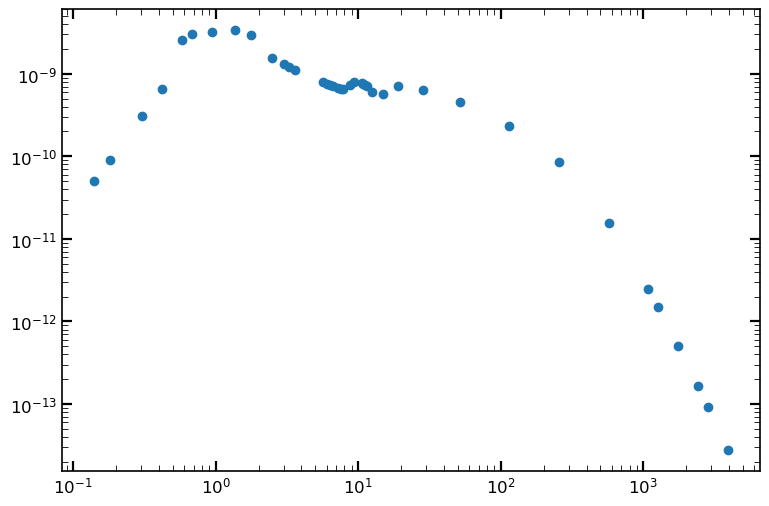

Lstar 1.7378
log
Teff 4365.16
log
fUV 0.026915
log
pUV 0.954993
log
amin 0.031623
log
amax 3981.07
log
apow 3.6
a_settle 0.001
log
Mg0.7Fe0.3SiO3[s] 0.57
fPAH 0.031623
log
PAH_charged 0.5
Mdisk 0.042954
log
Rin 0.199526
log
Rtaper 89.1251
log
epsilon 1.0
MCFOST_H0 12.0
MCFOST_BETA 1.15
incl 0.103074
E(B-V) 0.1
R(V) 3.1
Dist[pc] 100.0


In [60]:
data=np.loadtxt('./mock_flux.txt',skiprows=1)
lam_obs=data[:-1,0]
flux_obs=data[:-1,1]
sig_obs=data[:-1,2]

idx_list=[10,15,20,22,24,25,27,30,32,35,37,40,45,50,52,55,57,60,62,65,76,70,72,75,77,80,85,90,95,100,105,110,115,120,124,125,127,129,130,132]
lam_obs=lam_obs[idx_list]
flux_obs=flux_obs[idx_list]
sig_obs=sig_obs[idx_list]

plt.scatter(lam_obs,flux_obs)
plt.xscale('log')
plt.yscale('log')
plt.show()
dict_mock={}
with open('./mock_para.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        line_sp=line.split()
        para=line_sp[1]
        val=float(line_sp[0])
        print(para,val)
        if para in log_dict and log_dict[para]=='log':
            print('log')
            val=np.log10(val)
        dict_mock[para]=val
        

In [63]:
num_models=100

check_physics_and_training=True
min_wave=0.001
subfold='example/' #with a / please 
#subfold='test_DOTau_woSamplePrior_DIANA_data/' #with a / please 
#subfold='test_DOTau/' #with a / please 
#subfold='test_DOTau_DIANA_data/' #with a / please 
run_number=3
#sing_obs=['49Cet','DNTau','FTTau','RULup', 'MWC480', 'RECX15','DOTau', 'DFTau']  #, , ] the last one has no propper UV fit
#two_obs=['AATau', 'ABAur', 'BPTau', 'CITau', 'CYTau', 'DMTau', 'GMAur', 'HD100546', 'HD135344B', 'HD142666', 'HD163296', 'HD169142', 'HD95881', 'HD97048', 'LkCa15', 'RYLup', 'TWCha', 'TWHya', 'UScoJ1604-2130', 'V1149Sco']
#all_obj=['DOTau']#all_obj=['49Cet','AATau','DNTau']
fixed_paras=True
#all_obj=['HD163296']
#objects=all_obj#[ 'DOTau']#[ 'DOTau']#,'RECX15']#, 'DOTau', 'RECX15', 'RULup'] #'DFTau', 'FTTau', 'MWC480',

objects=['DNTau']

sample_prior=False

use_fix_reddening=True
weight=True

running=False
old_radius=False
use_diana_data=False
use_full_diana=True
input_list_fix=['Lstar','Teff','fUV', 'pUV', 'amin', 'amax', 'apow',
       'a_settle', 'Mg0.7Fe0.3SiO3[s]', 'fPAH',
       'PAH_charged', 'Rtaper',  'epsilon',
       'MCFOST_H0', 'MCFOST_BETA']
input_list_fix=[ 'amin', 'amax', 'apow', 'a_settle',
       'Mg0.7Fe0.3SiO3[s]', 'fPAH', 'PAH_charged', 'Rin',
       'Rtaper', 'epsilon', 'MCFOST_H0', 'MCFOST_BETA']
input_list_fix=['fUV','pUV']


#input_list_fix=['Lstar','Teff']



dict_fix={}
for key in input_list_fix:
    dict_fix[key]=dict_mock[key]
cut_obs=80

fold_string=bayesian_folder
if subfold!='':
    os.system(f'mkdir {fold_string}{subfold}')
    fold_string=fold_string+subfold
    
    
idx_rin, idx_rtaper, idx_amin, idx_amax, idx_fpah, idx_h0, idx_mdisk, idx_epsilon, idx_mcfost_b,idx_teff,idx_lstar= get_idxes(new_header_1=new_header_1)
for ob in objects:
    print('---------------')
    print('---------------')
    print(ob)
    print('---------------')
    print('---------------')
    # name of the output files
    outputfile = fold_string+ob+'_'+str(min_wave)+'_'+str(run_number)+'_weight_'+str(weight)+'stats.dat'
    if not os.path.isfile(outputfile):

        
        if not fixed_paras:
            input_list_fix=[]
        list_fixed, new_header,lower_lim,upper_lim,args=fixing_paras(list_fixed=input_list_fix,fixed_paras=fixed_paras)

        if 'incl' not in list_fixed:
            idx_incl=-1
        print(list_fixed)
        '''
        if use_diana_data or use_full_diana:
            dict_fix,dist,e_bv,R_V,lam_obs,flux_obs,sig_obs,filter_names,weights=load_para(ob=ob,min_wave=min_wave,setweighting=True) 
            if cut_obs!=0:

                lam_obs=lam_obs[:cut_obs]
                flux_obs=flux_obs[:cut_obs]
                sig_obs=sig_obs[:cut_obs]
                filter_names=filter_names[:cut_obs]
                weights=weights[:cut_obs]
        '''
        if use_fix_reddening:
            e_bv=0
            R_V=3.1
        e_bv=dict_mock['E(B-V)']
        R_V=dict_mock['R(V)']
        
        if not fixed_paras:
            dict_fix={}


        weights=np.ones_like(sig_obs)
        filter_names=np.array(['generic']*len(sig_obs))
        print(flux_obs)
        idx_fixed,idx_unfixed,value_fixed=find_idx_fixed()

        prior=prior_multinest
        
        #gettting weights for the linear interpolation
        interpolation_weights,interpolation_idx=linear_tf_get_weights(tf.constant(wavelength,'float32'),tf.constant(lam_obs,'float32'))
        
        prefix = fold_string+ob+'_'+str(min_wave)+'_'+str(run_number)+'_weight_'+str(weight)

        if running:
            # run MultiNest
            result = solve(LogLikelihood=loglike, Prior=prior, 
                           n_dims=len(new_header), outputfiles_basename=prefix, verbose=True,n_live_points = 1000)
            #print(find_idx_fixed())
            os.system('rm '+prefix+'*IS*')

mkdir: cannot create directory ‘./Output/example/’: File exists


12 5 9
15 12 16
11 13 14
---------------
---------------
DNTau
---------------
---------------

New shape
(672164, 16)
(16,)
(16,)
['fUV', 'pUV']
[5.069444e-11 9.022831e-11 3.097338e-10 6.616318e-10 2.570125e-09
 3.050848e-09 3.235343e-09 3.364775e-09 2.983422e-09 1.543696e-09
 1.310942e-09 1.216761e-09 1.117625e-09 7.907835e-10 7.593917e-10
 7.377858e-10 7.138060e-10 6.699444e-10 6.573272e-10 6.461927e-10
 7.474186e-10 7.304820e-10 7.910635e-10 7.664400e-10 7.288249e-10
 7.025992e-10 6.018089e-10 5.652294e-10 7.169329e-10 6.432415e-10
 4.580868e-10 2.321016e-10 8.468040e-11 1.577714e-11 2.499681e-12
 1.490576e-12 5.092958e-13 1.646534e-13 9.206510e-14 2.760893e-14]
fUV
pUV
Found 0.13971230387687683 between 0.13971230387687683 and 0.14704060554504395
Found 0.18040449917316437 between 0.18040449917316437 and 0.18986719846725464
Found 0.3060174882411957 between 0.3060174882411957 and 0.3592056930065155
Found 0.4216383993625641 between 0.4216383993625641 and 0.494922399520874
Found 0.5809

In [64]:
dist=dict_mock['Dist[pc]']
dist_log=np.log10(dict_mock['Dist[pc]'])
fluxRed_funct = np.log10(pyasl.unred(wavelength*10**4, np.ones(len(wavelength)), ebv=-e_bv, R_V=R_V))


In [65]:
print(dist_log)
print(lam_obs)
print(flux_obs)
print(sig_obs)
print(weights)
print(filter_names)

2.0
[1.397123e-01 1.804045e-01 3.060175e-01 4.216384e-01 5.809437e-01
 6.819162e-01 9.395608e-01 1.365333e+00 1.759445e+00 2.489560e+00
 3.033654e+00 3.262833e+00 3.628721e+00 5.657270e+00 6.062004e+00
 6.345165e+00 6.664492e+00 7.266173e+00 7.525531e+00 7.848970e+00
 1.088884e+01 8.714081e+00 9.302710e+00 1.057904e+01 1.107553e+01
 1.143108e+01 1.254793e+01 1.491683e+01 1.907720e+01 2.830480e+01
 5.162364e+01 1.150359e+02 2.563410e+02 5.712193e+02 1.084403e+03
 1.272880e+03 1.753806e+03 2.416436e+03 2.836432e+03 3.908105e+03]
[5.069444e-11 9.022831e-11 3.097338e-10 6.616318e-10 2.570125e-09
 3.050848e-09 3.235343e-09 3.364775e-09 2.983422e-09 1.543696e-09
 1.310942e-09 1.216761e-09 1.117625e-09 7.907835e-10 7.593917e-10
 7.377858e-10 7.138060e-10 6.699444e-10 6.573272e-10 6.461927e-10
 7.474186e-10 7.304820e-10 7.910635e-10 7.664400e-10 7.288249e-10
 7.025992e-10 6.018089e-10 5.652294e-10 7.169329e-10 6.432415e-10
 4.580868e-10 2.321016e-10 8.468040e-11 1.577714e-11 2.499681e-12
 1.49

In [66]:
feat=np.zeros((len(new_header)))
j=0
for i in range(len(new_header)):
    if new_header[i] in dict_fix:
        feat[i]=dict_fix[new_header[i]]
    else:
        feat[i]=np.mean([upper_lim[j],lower_lim[j]])
        j+=1

In [67]:
feat[-1]=19
print(10**feat[0])
print(10**feat[1])
feat[1]=3.5944444444444446
feat[0]=-0.4

1.2223422784454603
5708.358122175275


In [68]:
new_header

array(['Lstar', 'Teff', 'amin', 'amax', 'apow', 'a_settle',
       'Mg0.7Fe0.3SiO3[s]', 'fPAH', 'PAH_charged', 'Mdisk', 'Rin',
       'Rtaper', 'epsilon', 'MCFOST_H0', 'MCFOST_BETA', 'incl'],
      dtype='<U17')

In [69]:
sig_obs_multi=[]
for i in range(num_models):
    sig_obs_multi.append(sig_obs)
sig_obs_multi=np.array(sig_obs_multi).T
print(np.shape(sig_obs_multi))
flux_obs_multi=[]
for i in range(num_models):
    flux_obs_multi.append(flux_obs)
flux_obs_multi=np.array(flux_obs_multi).T
print(np.shape(flux_obs_multi))
weights_multi=[]
for i in range(num_models):
    weights_multi.append(weights)
weights_multi=np.array(weights_multi).T
print(np.shape(weights_multi))

#print(sig_obs_multi)

(40, 100)
(40, 100)
(40, 100)


In [70]:


scaled_cube=tf.Variable(tf.zeros_like(feat))

In [71]:
i=0
i+len(feat)-1

15

In [72]:
len(feat)

16

In [73]:
cube_idx_incl=[]
for i in range(num_models):
    cube_idx_incl.append([i,len(feat)-1]) #incl has to be the last entry in the not fixed cube
cube_idx_incl=np.array(cube_idx_incl)
idx_cube_all_wo_incl=np.zeros(((len(feat)-1)*num_models,2),int)
for i in range(len(idx_cube_all_wo_incl)):
    idx_cube_all_wo_incl[i,1]=i%(len(feat)-1)
#print(np.shape(idx_cube_all_wo_incl))
for i in range(np.shape(idx_cube_all_wo_incl)[0]):
#    print(idx_cube_all_wo_incl[i])
    idx_cube_all_wo_incl[i,0]=i//(len(feat)-1)
cube_idx_incl=tf.constant(cube_idx_incl,tf.int64)
idx_cube_all_wo_incl=tf.constant(idx_cube_all_wo_incl,tf.int64)

print(idx_cube_all_wo_incl)
#print(cube_idx_incl)
#print(np.shape(feat))

tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [99 12]
 [99 13]
 [99 14]], shape=(1500, 2), dtype=int64)


In [74]:
idx_unfixed

array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [75]:
idx_fixed_tot=np.zeros((len(idx_fixed)*num_models,2),int)
idx_unfixed_tot=np.zeros((len(idx_unfixed)*num_models,2),int)

for i in range(len(idx_fixed_tot)):
    idx_fixed_tot[i,1]=idx_fixed[int(i%(len(idx_fixed)))]
    idx_fixed_tot[i,0]=i//(len(idx_fixed))
    
for i in range(len(idx_unfixed_tot)):
    idx_unfixed_tot[i,1]=idx_unfixed[int(i%(len(idx_unfixed)))]
    idx_unfixed_tot[i,0]=i//(len(idx_unfixed))                            
                            

print(idx_fixed_tot[:30])
print(idx_unfixed_tot[:30])
        
idx_fixed=tf.constant(idx_fixed_tot,tf.int64)
idx_cube=tf.constant(idx_unfixed_tot,tf.int64)



[[ 0  2]
 [ 0  3]
 [ 1  2]
 [ 1  3]
 [ 2  2]
 [ 2  3]
 [ 3  2]
 [ 3  3]
 [ 4  2]
 [ 4  3]
 [ 5  2]
 [ 5  3]
 [ 6  2]
 [ 6  3]
 [ 7  2]
 [ 7  3]
 [ 8  2]
 [ 8  3]
 [ 9  2]
 [ 9  3]
 [10  2]
 [10  3]
 [11  2]
 [11  3]
 [12  2]
 [12  3]
 [13  2]
 [13  3]
 [14  2]
 [14  3]]
[[ 0  0]
 [ 0  1]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 1  0]
 [ 1  1]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]]


In [76]:
interpolation_weights=tf.constant(interpolation_weights)
print(interpolation_weights)

tf.Tensor(
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.4273766e-06 0.0000000e+00 9.9999827e-01
 9.9999821e-01 3.0604439e-05 0.0000000e+00 9.9999809e-01 0.0000000e+00
 6.7046149e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 9.9999046e-01 0.0000000e+00 9.9999654e-01 1.0000000e+00 2.2794620e-05
 0.0000000e+00 1.0000000e+00 0.0000000e+00 9.9999523e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.9999660e-01 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(40,), dtype=float32)


In [77]:
value_fixed

array([-1.57000562, -0.01999981])

In [78]:
#idx_fixed=tf.constant(idx_fixed)
#idx_unfixed=tf.constant(idx_unfixed)
value_fixed=tf.constant(np.tile(value_fixed,num_models),dtype=tf.float32)

print(value_fixed)

tf.Tensor(
[-1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.01999981 -1.5700057  -0.01999981
 -1.5700057  -0.01999981 -1.5700057  -0.

In [79]:
upper_lim_tf=tf.constant(upper_lim,tf.float32)
lower_lim_tf=tf.constant(lower_lim,tf.float32)

In [80]:
upper_lim

array([ 1.75039566e+00,  4.02520752e+00, -6.99005306e-01,  3.99997687e+00,
        4.99889410e+00, -1.00016046e+00,  6.99975827e-01, -6.98926760e-06,
        9.99998093e-01,  3.91306996e-01,  2.00173378e+00,  2.54406762e+00,
        2.49741212e+00,  3.49957256e+01,  1.39968912e+00,  8.70000000e+01])

In [81]:

list_feat=[]
for i in range(num_models):
    list_feat.append(feat)
list_feat=np.array(list_feat)
tf_feat=tf.constant(list_feat,dtype=tf.float32)
print(tf.shape(tf_feat))
print(tf_feat[0])
test_out=loglike(tf_feat,debug=False)#,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=True,timeit=False)
print(test_out)

tf.Tensor([100  16], shape=(2,), dtype=int32)
tf.Tensor(
[-0.4         3.5944445  -1.8494384   3.2386208   3.999457   -3.0000677
  0.5749938  -1.7499561   0.50000083 -2.61456    -0.02307284  1.6215199
  1.2487938  18.99791     1.1498458  19.        ], shape=(16,), dtype=float32)
tf.Tensor(
[-3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798
 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798 -3070.798

In [313]:
with tf.device('CPU:0'):

    %timeit loglike(tf_feat)#,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)
with tf.device('GPU:0'):
    %timeit loglike(tf_feat)#,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)


684 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
952 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
with tf.device('CPU:0'):

    %timeit loglike(tf_feat)#,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)
with tf.device('GPU:0'):
    %timeit loglike(tf_feat)#,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)


In [ ]:
%timeit loglike(tf_feat,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)

In [ ]:

def tape_grad(printing=False):
    with tf.GradientTape() as tape:
        tape.watch(tf_feat)
        test=loglike(tf_feat,model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,debug=False)
        grads = tape.gradient(test,tf_feat)
        if printing:
            print(test)
            print(grads)
tape_grad()            

In [ ]:

with tf.device('CPU:0'):
    %timeit tape_grad()        
with tf.device('GPU:0'):
    %timeit tape_grad()        


# HMCMC

In [82]:
min_wave=0.5
max_wave=' '


weight=True
hplanck = 6.62607554E-27        # Planck's constant
bk      = 1.38065812E-16        # Boltzmann's constant
cl      = 2.99792458E+10        # speed of light
Lsun    = 3.8260E+33            # solar luminosity
Msun    = 1.9889225E+33         # solar mass
Rsun    = 6.9599000E+10         # solar radius
grav    = 6.6725985E-08         # gravitational constant
pc      = 3.08568025E+18        # 1 parsec
mic     = 1.E-4                 # 1 micron
Ang     = 1.E-8                 # 1 Angstroem
Jansky  = 1.E-23                # 1 Jy in [erg/cm^2/s/Hz]
Wm2     = 1.E+3                 # 1 W/m^2 in [erg/cm^2/s]
nm      = 1.E-7                 # 1 nanometer
pi      = np.arccos(-1.0)
cPl1    = 2.0*hplanck*cl**2
cPl2    = hplanck*cl/bk    
sig_SB  = cPl1/cPl2**4*pi**5/15.0

def plot_model_uncertainties_names(y_true,y_pred, y_predict_set,model_wave,filter_list,folder,wavelength=wavelength,residual='Normal',save=False,save_name='',min_wave=min_wave,ylim='',errorbars=False,yerr='',weight=weight,max_wave=max_wave,plot_midIR=False,save_name_IR='',contours=True,num_walker=5):
    
    spec_colors={'SpitzerIRS':'tab:orange','nearIRspec':'tab:cyan','SPIREspec':'lightcoral',
                'PACSspec':'tan','<UV>':'cadetblue','ISOspec':'lime'}
           
    col = ['tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey',
       'tab:olive','navy','wheat','darkseagreen','darkred','rebeccapurple','rosybrown','deeppink',
       'black','darkolivegreen','crimson']

    fig = plt.figure(figsize=(9,6))
    ax  = fig.add_subplot(1,1,1)
    xmin = 0.07
    xmax = np.amax(model_wave)*1.5
    #ymin = 10**(np.log(np.amin([y_predict_set])-0.3))
    #ymax = 10**(np.log(np.amax([y_predict_set])+0.3))
    
    ax.set_xscale('log')
    ax.set_xlim([xmin,xmax])
    #ax.set_ylim([ymin,ymax])
    ax.set_xlabel(r'$\lambda\rm [\mu m]$', fontsize=20)
    ax.set_ylabel(r'$\nu F_\nu\rm [erg/cm^2\!/s]$', fontsize=20)
    ax.tick_params(labelsize=15)
    first=True
    if max_wave!=' ':
        idx=np.where(model_wave<=max_wave)[0]
    else:
        idx=np.arange(len(model_wave))
    if contours:
        x_model=model_wave[idx]
        y_model=y_predict_set[:,idx]
        print(np.shape(y_model))
        y_median=np.median(y_model,axis=0)
        y_std=np.percentile(y_model,50+68/2,axis=0)
        y_2std=np.percentile(y_model,50+95/2,axis=0)
        y_3std=np.percentile(y_model,50+99.9/2,axis=0)
        y_std_min=np.percentile(y_model,50-68/2,axis=0)
        y_2std_min=np.percentile(y_model,50-95/2,axis=0)
        y_3std_min=np.percentile(y_model,50-99.9/2,axis=0)
        print(np.shape(y_3std_min),np.shape(y_3std_min),np.shape(x_model))
        ax.fill_between(x_model,y_3std_min,y_3std,color='black',alpha=0.1)
        ax.fill_between(x_model,y_2std_min,y_2std,color='black',alpha=0.3)
        ax.fill_between(x_model,y_std_min,y_std,color='black',alpha=0.5)
        ax.plot(x_model,y_median,label='Model',alpha=1,color='black')

            
    else:
        
        
        cmap = cm.get_cmap('viridis')
        first=True
        len_set=len(y_predict_set)/num_walker
        count=0
        for y_predict in y_predict_set:
            if count/len_set>1.0:
                count-=len_set
            if first:
                first=False
                ax.plot(model_wave[idx],y_predict[idx],label='Model',alpha=0.1,color=cmap(count/len_set))

            ax.plot(model_wave[idx],y_predict[idx],alpha=0.1,color=cmap(count/len_set))
            count+=1
    yerr=np.array(yerr)
    Ndat=len(wavelength)
    #print(Ndat)
    filter_list2=np.array(filter_list)
    #give the spectral points always the same color:
    #print(filter_list)
    for spec_filt in spec_colors:
        fil = 'end'
        for i in range(0,Ndat):
            if filter_list[i] == spec_filt: 
                fil=filter_list[i]  
                #print(fil)
        if fil != 'end':
            i = str.find(fil,'.')
            if i>0: 
                fil = fil[0:i]
            ind = []
            for i in range(0,Ndat):
                  if fil in filter_list[i]: 
                    ind.append(i)
                    filter_list[i] = ' '
            xx = np.array(wavelength[ind])
            yy = np.array(y_true[ind])
            ye=np.array(yerr[ind])
            #print(fil)
                    
            if fil == 'SpitzerIRS':
                lSpitzer=xx
                FSpitzer=yy
            ax.plot(xx,yy,c=spec_colors[spec_filt],label=fil,linewidth=2)    
    for icol in range(0,20):
        fil = 'end'
        for i in range(0,Ndat):
            if filter_list[i] != ' ': 
                fil=filter_list[i]  
                #print(fil)
        if fil != 'end':
            i = str.find(fil,'.')
            if i>0: 
                fil = fil[0:i]
            ind = []
            for i in range(0,Ndat):
                  if fil in filter_list[i]: 
                    ind.append(i)
                    filter_list[i] = ' '

            xx = np.array(wavelength[ind])
            yy = np.array(y_true[ind])
            ye=np.array(yerr[ind])
            #print(fil)
            
            if errorbars:
                ax.errorbar(xx,yy,yerr=ye,c=col[icol],marker='D',label=fil,mec='black',mew=1,linestyle='None',ms=6)

            else:
                ax.scatter(xx,yy,s=50,c=col[icol],marker='D',label=fil,edgecolor='black',linewidth=1)


    axbox = ax.get_position()

    ax.set_title(f'{obj} - Single zone', fontsize=30)
    
    ax.axvline(x=min_wave,linestyle='dashed',color='black')


    #if not errorbars:
    #    ax1.scatter(wavelength,y_true,label='Observations',marker='+',color='tab:orange')

    '''if min_wave!=-1:
        f_ax1.set_xlim(left=min_wave)
    '''
    if ylim!='':
        f_ax.set_ylim(bottom=ylim[0],top=ylim[1])
    ax.set_xscale('log')
    ax.set_yscale('log')
    if max_wave!=' ':
        ax.set_xlim(right=max_wave)
    legend = ax.legend(frameon=True,ncol=2,markerscale=0.7,scatterpoints=1,labelspacing=0.0,loc=(axbox.x0-0.02, axbox.y0 - 0.02),fancybox=True)
    for label in legend.get_texts():
        label.set_fontsize('large')

    plt.tight_layout()
    if save:
        plt.savefig(save_name,bbox_inches='tight')
    plt.show()
    if plot_midIR:
        
        xmin = 3.0
        xmax = 15.0
        fig  = plt.figure(figsize=(9,6))
        ax   = fig.add_subplot(1,1,1)
        #ind  = np.where(lSpitzer<xmax)
        #ymin = np.amin([FSpitzer[ind]])*0.5
        #ymax = np.amax([FSpitzer[ind]])*1.5
        #ymin = 0.0
        ind  = np.where((model_wave>4.0) & (model_wave<xmax))
        ymax= np.max(y_predict_set[:,ind])*1.5
        ymin=np.min(y_predict_set[:,ind])*0.5
        #ymax = np.max([ymax,ymax2])
        #ymin = np.min([ymin,ymin2])
        #print(ymax,ymax2,ymin)
        #ax.set_xscale('log')
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
        #ax.set_xscale('log')
        ax.set_yscale('log')
        
        #ax.set_xlim([xmin,xmax])
        #ax.set_ylim([ymin,ymax])
        ax.set_xlabel(r'$\lambda\rm [\mu m]$', fontsize=20)
        ax.set_ylabel(r'$\nu F_\nu\rm [erg/cm^2\!/s]$', fontsize=20)
          #      for icol in range(0,20):
        #print(filter_list2)
                
        if contours:
            x_model=model_wave[idx]
            y_model=y_predict_set[:,idx]
            print(np.shape(y_model))
            y_median=np.median(y_model,axis=0)
            y_std=np.percentile(y_model,50+68/2,axis=0)
            y_2std=np.percentile(y_model,50+95/2,axis=0)
            y_3std=np.percentile(y_model,50+99.9/2,axis=0)
            y_std_min=np.percentile(y_model,50-68/2,axis=0)
            y_2std_min=np.percentile(y_model,50-95/2,axis=0)
            y_3std_min=np.percentile(y_model,50-99.9/2,axis=0)
            print(np.shape(y_3std_min),np.shape(y_3std_min),np.shape(x_model))
            ax.fill_between(x_model,y_3std_min,y_3std,color='black',alpha=0.1)
            ax.fill_between(x_model,y_2std_min,y_2std,color='black',alpha=0.3)
            ax.fill_between(x_model,y_std_min,y_std,color='black',alpha=0.5)
            ax.plot(x_model,y_median,label='Model',alpha=1,color='black')


        else:
            
            cmap = cm.get_cmap('viridis')
            first=True
            len_set=len(y_predict_set)/num_walker
            count=0
            for y_predict in y_predict_set:
                if count/len_set>1.0:
                    count-=len_set
                if first:
                    first=False
                    ax.plot(model_wave[idx],y_predict[idx],label='Model',alpha=0.1,color=cmap(count/len_set))

                ax.plot(model_wave[idx],y_predict[idx],alpha=0.1,color=cmap(count/len_set))
                count+=1
        for spec_filt in spec_colors:
            fil = 'end'
            for i in range(0,Ndat):
                if filter_list2[i] == spec_filt: 
                    fil=filter_list2[i]  
                    #print(fil)
            if fil != 'end':
                i = str.find(fil,'.')
                if i>0: 
                    fil = fil[0:i]
                ind = []
                for i in range(0,Ndat):
                      if fil in filter_list2[i]: 
                        ind.append(i)
                        filter_list2[i] = ' '

                xx = np.array(wavelength[ind])
                yy = np.array(y_true[ind])
                ye=np.array(yerr[ind])
                #print(fil)
                continue_plot=False
                for xx_point in xx:
                    if xx_point>xmin and xx_point<xmax:
                        continue_plot=True
                        break# or ((float(xx[-1])>xmin and float(xx[-1])<xmax)): 
                if continue_plot:
                    ax.plot(xx,yy,c=spec_colors[spec_filt],label=fil,linewidth=2)   

        for icol in range(0,20):
            fil = 'end'
            for i in range(0,Ndat):
                if filter_list2[i] != ' ': 
                    fil=filter_list2[i]  
                    #print(fil)
            if fil != 'end':

                i = str.find(fil,'.')
                if i>0: 
                    fil = fil[0:i]
                ind2 = []
                for i in range(0,Ndat):
                      if fil in filter_list2[i]: 
                        ind2.append(i)
                        filter_list2[i] = ' '

                xx = np.array(wavelength[ind2])
                yy = np.array(y_true[ind2])
                ye=np.array(yerr[ind2])
                #print(fil)
                continue_plot=False
                for xx_point in xx:
                    if xx_point>xmin and xx_point<xmax:
                        continue_plot=True
                        break# or ((float(xx[-1])>xmin and float(xx[-1])<xmax)): 
                if continue_plot:
                    if errorbars:

                        ax.errorbar(xx,yy,yerr=ye,c=col[icol],marker='D',label=fil,mec='black',mew=1,linestyle='None',ms=6)
                    else:
                        ax.scatter(xx,yy,s=50,c=col[icol],marker='D',label=fil,edgecolor='black',linewidth=1)

        axbox = ax.get_position()

        legend = ax.legend(frameon=True,ncol=2,markerscale=0.7,scatterpoints=1,labelspacing=0.0,loc=(axbox.x0 - 0.1, axbox.y0 + 0.008),fancybox=True)
        for label in legend.get_texts():
            label.set_fontsize('large')
            
        list_yticks=np.array([10**-14,5*10**-14,10**-13,5*10**-13,10**-12,5*10**-12,10**-11,5*10**-11,10**-10,5*10**-10,10**-9,5*10**-9,10**-8,5*10**-8,10**-7,5*10**-7])
        list_ylabels=np.array(['$10^{-14}$','$5 \cdot 10^{-14}$','$10^{-13}$','$5 \cdot 10^{-13}$','$10^{-12}$','$5 \cdot 10^{-12}$','$10^{-11}$','$5 \cdot 10^{-11}$',
                      '$10^{-10}$','$5 \cdot 10^{-10}$','$10^{-9}$','$5 \cdot 10^{-9}$','$10^{-8}$','$5 \cdot 10^{-8}$','$10^{-7}$','$5 \cdot 10^{-7}$'])
        ind=np.where((list_yticks>ymin) & (list_yticks<ymax))[0]
        #print(ind)
        ax.set_yticks(list_yticks[ind],list_ylabels[ind])
        ax.tick_params(labelsize=15)
        ax.set_title(f'{obj} - Single zone', fontsize=30)
        #------- export plots --------
        fig.tight_layout()
        if save:
            plt.savefig(save_name_IR,bbox_inches='tight')
        plt.show()
        

In [83]:

scaled_cube=tf.Variable(tf.zeros_like(tf_feat))

In [84]:
  
def f1(cube, penalty_exp=2,penalty_offset=4): 
    maxi=tf.math.reduce_max(cube[:-1])-1.0
    mini=tf.math.abs(tf.math.reduce_min(cube[:-1]))
    furthest=tf.math.maximum(maxi,mini)
    return -furthest*10**penalty_exp-1.0*10**penalty_offset


In [85]:
new_header

array(['Lstar', 'Teff', 'amin', 'amax', 'apow', 'a_settle',
       'Mg0.7Fe0.3SiO3[s]', 'fPAH', 'PAH_charged', 'Mdisk', 'Rin',
       'Rtaper', 'epsilon', 'MCFOST_H0', 'MCFOST_BETA', 'incl'],
      dtype='<U17')

In [86]:

@tf.function  
def prior_and_likelihood(cube):
    likes=loglike(prior_multinest(cube),model_uncertainty=True, Knn_uncertainty=False, penalty_exp=10,penalty_offset=20,debug=False,timeit=False)
    posterior = tf.TensorArray(dtype=tf.float32, size=(num_models))
    for i in range(num_models):
        cond_max=tf.reduce_any(tf.greater(cube[i],tf.constant(1.0,shape=(len(new_header),))))
        cond_min=tf.reduce_any(tf.less(cube[i],tf.constant(0.0,shape=(len(new_header),))))

        #cond_max_incl=tf.greater(cube[i,-1],tf.constant(87.13,shape=(1,)))
        #cond_min_incl=tf.less(cube[i,-1],tf.constant(18.19,shape=(1,)))
        dummy=tf.reduce_any([cond_max,cond_min])
        post=tf.cond(dummy,lambda: f1(cube=cube[i], penalty_exp=10,penalty_offset=20), lambda: likes[i])
        posterior=posterior.write(i,post)
    return posterior.stack()



@tf.function  
def prior_and_likelihood_single(cube):
    cond_max=tf.reduce_any(tf.greater(cube,tf.constant(1.0,shape=(len(new_header),))))
    cond_min=tf.reduce_any(tf.less(cube,tf.constant(0.0,shape=(len(new_header),))))
    

    dummy=tf.reduce_any([cond_max,cond_min])
    return tf.cond(dummy,lambda: f1(cube=cube, penalty_exp=2,penalty_offset=4), lambda: loglike_single(prior_multinest(cube),model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,penalty_offset=4,debug=False,timeit=False))
    

In [87]:
num_test=num_models*50
test_input_wo_incl=tf.random.uniform(shape=(num_test,len(new_header)-1),minval=0.0,maxval=1.00,dtype=tf.float32)
incl_test=tf.random.uniform(shape=(num_test,1),minval=18.0,maxval=85.,dtype=tf.float32)
test_input=tf.concat([test_input_wo_incl,incl_test],axis=1)

In [88]:
strict=True

if num_models<=200:
    num_test=5000
else:
    num_test=10000
    

if strict:
    test_input=tf.random.uniform(shape=(num_test,len(new_header)),minval=0.1,maxval=0.90,dtype=tf.float32)
else:
    test_input=tf.random.uniform(shape=(num_test,len(new_header)),minval=0.0,maxval=1.00,dtype=tf.float32)
   

In [89]:
idx_cube_single=idx_cube[:len(new_header)]
idx_fixed_single=idx_fixed[:len(input_list_fix)]
value_fixed_single=value_fixed[:len(input_list_fix)]

In [90]:

cube_idx_incl_single=tf.constant([[0,len(new_header)-1]],tf.int64)

idx_cube_all_wo_incl_single=np.zeros((len(new_header)-1,2))
idx_cube_all_wo_incl_single[:,1]=np.arange(0,len(new_header)-1)
idx_cube_all_wo_incl_single=tf.constant(idx_cube_all_wo_incl_single,tf.int64)


def precheck(samp,strict=False,debug=False):
    cube=prior_multinest(samp)
    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            cube_incl=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)   

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube_incl,value_fixed_single,debug=debug)   
        else:

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube,value_fixed_single,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            #print(angle_mcfost)
            
            feat=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost,debug=debug)   

        else:
            feat=cube
    penalty=tf.constant(0.0)
    #check if taper radius is larger than inner radius
    if strict:
        check_rad= tf.math.greater_equal(feat[idx_rin]+0.04139,feat[idx_rtaper]) # corrisponding to log(1.1rin)= logrin+log1.1
    else:
        check_rad= tf.math.greater_equal(feat[idx_rin],feat[idx_rtaper]) # for single zone this is without 10**

    #print('Rin/Rtaper')
      #penalty=tf.cond(check_rad,lambda: increase_penalty(penalty,(feat[idx_rin]-feat[idx_rtaper])*10**5-10**10), lambda: increase_penalty(penalty,0.0))
    
    penalty2=tf.cond(check_rad,lambda: -(feat[idx_rin]-feat[idx_rtaper])*10**5-10**10, lambda: tf.constant(0.0))

    #checking if the star is shielded
    shield_val=incl_NN(feat)
    #print(shield_val)
    #print(np.shape(shield_val))
    if strict:
        check_shield=tf.greater_equal(shield_val,lim_shielded*0.5) 
    else:
        check_shield=tf.greater_equal(shield_val,lim_shielded) 
        
    penalty3=tf.cond(check_shield,lambda:-shield_val[0][0]*10**5-10**10, lambda:tf.constant(0.0))

    #checking if the star is possible
    temp=feat[idx_teff]
    lum=feat[idx_lstar]
    if strict:
        penalty4=tf.cond(check_if_in_strict_mask(temp=temp,lum=lum),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp,lum=lum,penalty_exp=5,penalty_offset=10))
    else:
        penalty4=tf.cond(check_if_in_mask(temp=temp,lum=lum),lambda:tf.constant(0.0), lambda:penalty_hrd(temp=temp,lum=lum,penalty_exp=5,penalty_offset=10))
        
                                                           # the stellar parameters should always be fixed

        # checking if the inner disk radius is possible
    rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
  
    if strict:
        check_rmin=tf.math.less(feat[idx_rin]-0.045757,rmin) # corrisponding to log(0.9rin)= logrin+log0.9
    else:
        check_rmin=tf.math.less(feat[idx_rin],rmin)
    
    penalty5=tf.cond(check_rmin,lambda:-(rmin-feat[idx_rin])*10**5-10**10, lambda: tf.constant(0.0))

    if strict:
        check_rmax=tf.math.greater(feat[idx_rin],rmax)
    else:
        check_rmax=tf.math.greater(feat[idx_rin]+0.04139,rmax)
        
    penalty6=tf.cond(check_rmax,lambda:-(feat[idx_rin]-rmax)*10**5-10**10, lambda:tf.constant(0.0))

    stellar_mass=predict_stellar_mass(temp=temp,lum=lum)
    mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
    if debug:
        print('Mass of disk',mdisk_min,mdisk_max,feat[idx_mdisk])
    mdisk=tf.cast(feat[idx_mdisk],tf.float32)
    
    if strict:
        checkmmin=tf.math.less(mdisk-0.04576,mdisk_min) #corrisponding to 10% on log scale

    else:    
        checkmmin=tf.math.less(mdisk,mdisk_min)
    penalty7=tf.cond(checkmmin,lambda:-(mdisk_min-mdisk)*10**5-10**10, lambda:tf.constant(0.0))

    if strict:
        checkmmax=tf.math.greater(mdisk+0.04139,mdisk_max) #corrisponding to 10% on log scale
    else:
        checkmmax=tf.math.greater(mdisk,mdisk_max)
    
    penalty8=tf.cond(checkmmax,lambda:-(mdisk-mdisk_max)*10**5-10**10, lambda:tf.constant(0.0))
    tot_penalty=tf.add(penalty,tf.add(penalty2,tf.add(penalty3,tf.add(penalty4,tf.add(penalty5,tf.add(penalty6,tf.add(penalty7,penalty8)))))))
    if tot_penalty==0.0:
        return True
    else:
        return False

 create starting points

In [91]:
good_start=[]
like_values=[]
paras=[]
max_val=-1e10
for i in range(len(test_input)):
    para=test_input[i]
    if precheck(para,strict=True):
        print(i)
        good_start.append(i)
        like=prior_and_likelihood_single(para)
        like_values.append(like)
        paras.append(para)
        if like>max_val:
            max_val=like
            #print(max_val)
           # print('------')
    if len(good_start)>num_models:
        break

1


2023-09-06 12:12:17.370988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/43764' with dtype float and shape [1000]
	 [[{{node cond/43764}}]]


10
21
27
34
56
60
62
70
75
100
117
128
144
179
184
189
191
192
214
216
217
224
230
239
244
274
315
322
323
335
345
369
371
378
379
380
404
407
409
418
438
443
447
450
477
494
496
535
559
573
581
584
588
601
606
619
635
659
694
700
772
780
788
799
818
821
827
840
848
849
850
855
865
878
881
885
894
900
913
923
937
944
951
974
995
1004
1005
1008
1014
1028
1030
1036
1060
1062
1066
1095
1100
1103
1104
1114


In [92]:
print('Fraction of accepted points in the precheck:')
print(len(good_start)/len(test_input))
print('This is an indication on how much of the area is forbidden, with strict criterion')

Fraction of accepted points in the precheck:
0.0202
This is an indication on how much of the area is forbidden, with strict criterion


In [93]:
sort=False
if sort:
    sorted_likes=sorted(((value, index) for index, value in enumerate(like_values)), reverse=True)
    indices=np.array(sorted_likes[:num_models],'int32')[:,1]
else:
    indices=[]
    for i in np.random.choice(len(paras), num_models, replace=False):
        indices.append(i)
    
list_good=np.concatenate( [paras[x] for x in indices],axis=0).reshape(num_models,len(new_header))
print(np.shape(list_good))
print(list_good[0])
print(paras[indices[0]])
good_ten=tf.constant(list_good)

(100, 16)
[0.21235171 0.14710817 0.8328066  0.26109028 0.5290082  0.29932708
 0.28603286 0.8838341  0.77580166 0.522707   0.6223059  0.51333714
 0.8022034  0.7108943  0.5731645  0.44484755]
tf.Tensor(
[0.21235171 0.14710817 0.8328066  0.26109028 0.5290082  0.29932708
 0.28603286 0.8838341  0.77580166 0.522707   0.6223059  0.51333714
 0.8022034  0.7108943  0.5731645  0.44484755], shape=(16,), dtype=float32)


In [94]:

log_vals=loglike(prior_multinest(good_ten),model_uncertainty=True, Knn_uncertainty=False, penalty_exp=2,penalty_offset=4,debug=False,timeit=False)
print('Best/Worst likelihood',np.max(log_vals),np.min(log_vals))

Best/Worst likelihood 420.04962 -6311.5005


In [97]:
lim1=np.load('./data/lim1_hrd.npy')
lim2=np.load('./data/lim2_hrd.npy')
lim3=np.load('./data/lim3_hrd.npy')
lim4=np.load('./data/lim4_hrd.npy')
print(np.shape(lim1))

(2, 86)


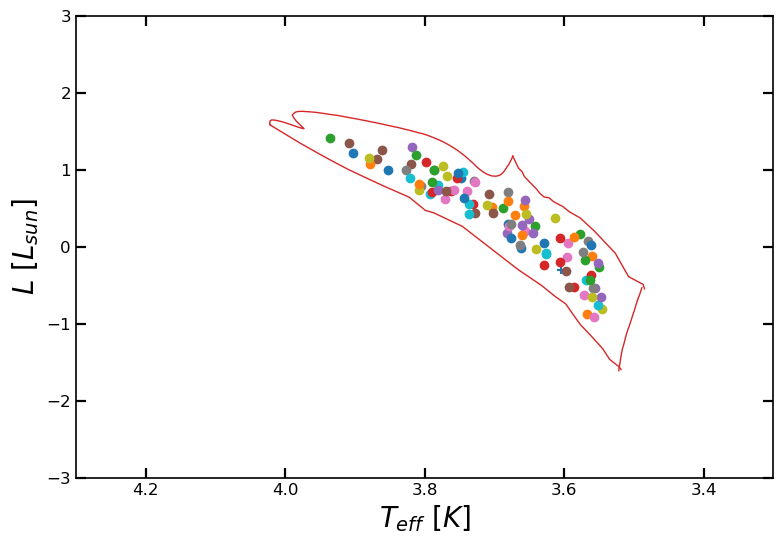

In [98]:


plt.plot(lim1[0],lim1[1],linestyle='solid',color='tab:red',lw=1)
plt.plot(lim2[0],lim2[1],linestyle='solid',color='tab:red',lw=1)
plt.plot(lim3[0],lim3[1],linestyle='solid',color='tab:red',lw=1)
plt.plot(lim4[0],lim4[1],linestyle='solid',color='tab:red',lw=1)


for i in range(len(good_start)):
    prior_good=prior_multinest(test_input[good_start[i]])
    
    plt.scatter(prior_good[1],prior_good[0],marker='+')

for i in range(len(good_ten)):
    prior_good=prior_multinest(good_ten[i])
    
    plt.scatter(prior_good[1],prior_good[0])


plt.xlabel(r'$T_{eff} \ [K]$')
plt.ylabel(r'$L \ [L_{sun}]$')
plt.xlim([4.3,3.3])
plt.ylim([-3,3])
plt.show()


single

In [99]:

#test_input=tf.random.uniform(shape=(10,18,),minval=0.5,maxval=0.56,dtype=tf.float32)
# Initialize the HMC transition kernel.
num_results = int(1e2)
num_burnin_steps = int(1e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=prior_and_likelihood_single,
        num_leapfrog_steps=5,
        step_size=0.00005),
    num_adaptation_steps=int(num_burnin_steps * 0.8),
    target_accept_prob=0.6)
@tf.function
def run_chain(input_set):

    samples, kernel_results = tfp.mcmc.sample_chain(
                                                num_results=num_results,
                                                num_burnin_steps=num_burnin_steps,
                                                current_state=input_set,
                                                kernel=adaptive_hmc,
                                                trace_fn=lambda current_state, kernel_results: kernel_results)
    #sample_mean = tf.reduce_mean(samples)
    #sample_stddev = tf.math.reduce_std(samples)
    return samples, kernel_results #sample_mean, sample_stddev, is_accepted,


tot_samples=[]
tot_kernel_results=[]
for i in range(len(good_start)): #1
    with tf.device('CPU:0'):
        samples,kernel_results = run_chain(test_input[good_start[i]])
    tot_kernel_results.append(kernel_results)
    tot_samples.append(samples)

2023-09-06 12:13:50.857505: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/StatefulPartitionedCall/cond_227/output/_980'


multi at the same time

In [ ]:
develop=False
#test_input=tf.random.uniform(shape=(10,18,),minval=0.5,maxval=0.56,dtype=tf.float32)
# Initialize the HMC transition kernel.
num_results = int(1e3)
num_burnin_steps = int(1e4)
step_size=0.002
step_size = tf.fill([num_models,1], step_size)
#print(step_size)
target_accept_prob=0.80
target_accept_prob = tf.fill([num_models], target_accept_prob)
if develop:
    num_adaptation_steps=int(0.8*num_results+num_burnin_steps)
else:
    num_adaptation_steps=int(num_burnin_steps * 0.8)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=prior_and_likelihood,
        num_leapfrog_steps=5,
        step_size=step_size),
    
    num_adaptation_steps=num_adaptation_steps,
    adaptation_rate=0.01,
    target_accept_prob=target_accept_prob)
@tf.function
def run_chain(input_set):

    samples, kernel_results = tfp.mcmc.sample_chain(
                                                num_results=num_results,
                                                num_burnin_steps=num_burnin_steps,
                                                current_state=input_set,
                                                kernel=adaptive_hmc,
                                                #parallel_iterations=10,
                                                trace_fn=lambda current_state, kernel_results: kernel_results)
    #sample_mean = tf.reduce_mean(samples)
    #sample_stddev = tf.math.reduce_std(samples)
    return samples, kernel_results #sample_mean, sample_stddev, is_accepted,




with open(f"start_time_TF.txt", mode='w') as file:
    file.write('Start time: %s.\n' % time.time())
tot_samples=[]
tot_kernel_results=[]
for i in range(1): #len(good_start)
    with tf.device('CPU:0'):
        samples,kernel_results = run_chain(good_ten)
    tot_kernel_results.append(kernel_results)
    tot_samples.append(samples)
    
with open(f"End_time_TF.txt", mode='w') as file:
    file.write('Start time: %s.\n' % time.time())


2023-09-06 12:28:34.825743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/1266207' with dtype int64 and shape [100,2]
	 [[{{node mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/1266207}}]]
2023-09-06 12:28:59.776953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'mcmc_sample_chain/trace_scan/whil

In [ ]:
accept_2d=[]
for i in range(len(tot_kernel_results)):
    accept_2d.append(tot_kernel_results[i][0][1])
print(np.shape(accept_2d))
fig = plt.figure()
if len(np.shape(accept_2d[0]))==2:
    ax = fig.add_subplot(111)
    ax.imshow(np.array(accept_2d)[0].T, aspect='auto', cmap=plt.cm.gray, interpolation=None)#'nearest')
    plt.xlabel('Steps')
    plt.ylabel('Walkers')
    #plt.xticks(xticks,xticks_labels)
    #plt.yticks(xticks,yticks_labels)
else:
    plot_one_d=np.zeros(len(accept_2d[0]))
    plot_one_d[np.where(np.array(accept_2d[0])==True)[0]]+=1.0
    plt.scatter(np.arange(len(accept_2d[0])),plot_one_d)
plt.show()    
accept=np.array(accept_2d).flatten()
print(len(accept))
print('Acceptance ratio',len(np.where(accept==True)[0])/len(accept))

here we keep the stuck step the number of times if was stuck

In [ ]:

tot_samples_ar=np.array(tot_samples)
print(np.shape(tot_samples_ar))
reshaped_ar=np.reshape(tot_samples_ar,(int(len(tot_samples_ar.flatten())/len(new_header)),len(new_header)))
print(np.shape(np.reshape(tot_samples_ar,(int(len(tot_samples_ar.flatten())/len(new_header)),len(new_header)))))
filtered_ar=reshaped_ar.copy()


In [ ]:
save_post=True
if save_post:
    name_post='test_multi'
    np.save('./saved_hmcs/'+name_post,filtered_ar)

In [102]:
load_post=False
name_post_load='fixed_star_long'
if load_post:
    name_post=name_post_load
    filtered_ar=np.load(f'./saved_hmcs/{name_post_load}.npy')

In [ ]:
priored_ar=np.array(prior_multinest(filtered_ar))

In [ ]:
lims=np.zeros((np.shape(filtered_ar)[1],2))
lims[:,1]=1.0

lims_scaled=np.zeros((np.shape(filtered_ar)[1],2))
lims_scaled[:,0]=lower_lim
lims_scaled[:,1]=upper_lim


In [ ]:
plot_corner=True
idx_fig=name_post

In [ ]:
truths=[]
for key in dict_mock:
    if key in new_header:
        val=dict_mock[key]
        if key=='incl':
            val=mcfost_val_to_angle(val)
        truths.append(val)
truths=np.array(truths)
print(truths)

In [ ]:
    CORNER_KWARGS = dict(
        smooth=.9,
        label_kwargs=dict(fontsize=20),
        title_kwargs=dict(fontsize=24,loc='left'),
        levels=[0.68, 0.95],
        quantiles=[0.5],
        plot_density=False,
        plot_datapoints=True,
        fill_contours=True,
        plot_contours=True,
        show_titles=True,
        range=lims_scaled,
        truths=truths)

fig = corner.corner(priored_ar, labels=new_header, color='tomato', **CORNER_KWARGS)

if plot_corner: plt.savefig(f'corner_{idx_fig}.png')
plt.show()

In [ ]:
y_model_set=[]
interp_flux_set=[]
debug=False
devided_by=1000#len(filtered_ar)
count=0
idx=np.arange(0,len(filtered_ar))
np.random.shuffle(idx)
for i in range(0,len(filtered_ar),max(int(len(filtered_ar)/devided_by),1)):
    samp=filtered_ar[idx[i]]
    cube=prior_multinest(samp)
    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            if debug:
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)
            cube_incl=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)   

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube_incl,value_fixed_single,debug=debug)   
        else:

            feat=combine_arrays_single(idx_cube_single,idx_fixed_single,cube,value_fixed_single,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            feat=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,
                                       tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost,debug=debug)   

        else:
            feat=cube

    ymodel=model(feat)
    
    y_model_set.append(ymodel)
    interp_flux=spline(wavelength,ymodel,lam_obs)
    interp_flux_set.append(interp_flux)
    count+=1
    if count%10==0:
        print(str(np.round(count/(devided_by)*100,0))+'%',end='\r',flush=True)
y_model_set=np.array(y_model_set)

interp_flux_set=np.array(interp_flux_set)

In [ ]:
subfold='fixed_paras/'
save_fold_png='/home/tkaeufer/data/Large_SED_sample_data/pngs/models/'+subfold
os.system(f'mkdir {save_fold_png}')
obj=ob
end='pdf'
save_name=f'{save_fold_png}sed_uncertainties/New_data_{obj}_{min_wave}_{run_number}_simple_plot_single.{end}'

save_name1=f'{save_fold_png}New_data_{obj}_{min_wave}_{run_number}_diana_plot_single_track.{end}'
save_name2=f'{save_fold_png}New_data_{obj}_{min_wave}_{run_number}_diana_plot_single.{end}'

save_name3=f'{save_fold_png}New_data_{obj}_{min_wave}_{run_number}_midIR_plot_single.{end}'
folder=f'/minthome/chameleontfk1/Grid/DIANA_SEDS/{obj}'


plot_model_uncertainties_names(flux_obs,interp_flux_set,y_model_set,wavelength,filter_list=filter_names.copy(),folder=folder, wavelength=lam_obs,residual='Normal',save=False,save_name=save_name1,ylim='',min_wave=-1,errorbars=True,yerr=sig_obs,max_wave=max_wave,save_name_IR=save_name3,contours=False,num_walker=1)
plot_model_uncertainties_names(flux_obs,interp_flux_set,y_model_set,wavelength,filter_list=filter_names.copy(),folder=folder, wavelength=lam_obs,residual='Normal',save=False,save_name=save_name2,ylim='',min_wave=-1,errorbars=True,yerr=sig_obs,max_wave=max_wave,save_name_IR=save_name3,contours=True,plot_midIR=True)